In [1]:
# Cell 1: 라이브러리 및 설정
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import streamlit as st # GUI용 (Cell 12에서만 사용)
import os
import optuna

# 데이터 경로 정의 (파일명 확인 및 수정)
data_path = "/Users/yeojoon/Documents/PyWorkspace_CreativeDesign/TrainSet0507_NoDuplicatesHV.xlsx" #TrainSet0507_NoDuplicates

# 장치 설정 (가능하면 GPU/MPS, 아니면 CPU 사용)
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f"사용 장치: {device}")

# 재현성을 위한 랜덤 시드 설정
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
if device == 'cuda':
    torch.cuda.manual_seed(seed)
elif device == 'mps':
     pass

print("라이브러리 임포트 및 설정 완료.")

사용 장치: mps
라이브러리 임포트 및 설정 완료.


In [2]:
# Cell 2: 데이터 로딩 및 초기 검사

try:
    # 'Tensile' 시트 로드
    df_tensile = pd.read_excel(data_path, sheet_name='Tensile', header=0)
    print("--- Tensile 시트 ---")
    print(f"형태: {df_tensile.shape}")
    print("\n컬럼:", df_tensile.columns.tolist())
    print("\n처음 5행:\n", df_tensile.head())
    print("\n데이터 타입:\n", df_tensile.dtypes)
    print("\n결측치 요약:\n", df_tensile.isnull().sum())

except FileNotFoundError:
    print(f"오류: {data_path}에서 파일을 찾을 수 없습니다")
except Exception as e:
    print(f"데이터 로딩 중 오류 발생: {e}")

# 필요한 컬럼명 확인 (주석)
# E: 'E'
# YS: 'YS'
# TS: 'TS'
# HB: 'HB'
# HV: 'HV'
# sf: 'sf' (sigma_f')
# b: 'b'
# ef: 'ef' (epsilon_f')
# c: 'c'


# np_col = "n'" # 선택사항
# kp_col = "K' (MPa)" # 선택사항


--- Tensile 시트 ---
형태: (934, 19)

컬럼: ['Material', 'HeatTreatment', 'E', 'YS', 'TS', 'EL', 'RA', 'K', 'n', 'Unnamed: 9', 'HB', 'sy', 'np', 'Kp', 'sf', 'b', 'ef', 'c', '특이사항']

처음 5행:
   Material HeatTreatment      E   YS     TS    EL   RA      K      n  \
0   0.6040           NaN  140.0  420  570.0   NaN  NaN  902.0  0.130   
1   0.7040           NaN  165.0  323  470.0  17.3  NaN  514.0  0.076   
2   0.7060           NaN  158.0  382  632.0     7  NaN  507.0  0.043   
3   0.7060           NaN  175.0  480  738.0   4.4  NaN    NaN    NaN   
4   0.8155           NaN  155.0  389  600.0     5  NaN  582.0  0.073   

   Unnamed: 9   HB  sy     np    Kp   sf      b      ef      c  \
0         NaN  NaN NaN  0.153  1012  646 -0.078  0.0353 -0.451   
1         NaN  NaN NaN  0.065   677  851 -0.075  9.7123 -1.016   
2         NaN  NaN NaN  0.076   750  720 -0.058  0.7236 -0.782   
3         NaN  NaN NaN  0.103   936  805 -0.067  0.2314 -0.652   
4         NaN  NaN NaN  0.128   911  712 -0.073  0.14

In [3]:
# Cell 3: 컬럼 이름 변경 및 타입 변환

# --- 컬럼 이름 매핑 정의 (실제 파일 컬럼명 기준) ---
column_mapping = {
    'E': 'E_GPa',
    'YS': 'YS_MPa',
    'TS': 'TS_MPa',
    'HB': 'HB',
    'HV': 'HV',
    "sf": 'spf_MPa',
    'b': 'b',
    "ef": 'epf',
    'c': 'c',
    # 사용할 경우 선택적 컬럼 추가
    # "n'": 'np',
    # "K' (MPa)": 'Kp_MPa',
    # 'Material Name', 'RA (%)' 등과 같은 다른 관련 컬럼 추가
    #'RA': 'RA_percent' # RA가 존재하고 필요한 경우 예시
}

# 사용할 컬럼만 선택 및 이름 변경
required_cols = list(column_mapping.keys())
available_cols = [col for col in required_cols if col in df_tensile.columns]
missing_cols = [col for col in required_cols if col not in available_cols]

print(f"\n사용 가능한 컬럼: {available_cols}")
if missing_cols:
    print(f"경고: 다음 컬럼이 데이터에 없습니다: {missing_cols}. 해당 컬럼 없이 진행합니다.")
    # 필수 컬럼 누락 시 에러 처리 또는 중지 로직 추가 가능

# 사용 가능한 컬럼만으로 매핑 재생성
column_mapping_available = {k: v for k, v in column_mapping.items() if k in available_cols}

df = df_tensile[available_cols].copy()
df.rename(columns=column_mapping_available, inplace=True)

hv_col_exists = 'HV' in df.columns

# 숫자형 변환 (오류는 NaN)
numeric_cols_base = ['E_GPa', 'YS_MPa', 'TS_MPa', 'HB', 'spf_MPa', 'b', 'epf', 'c']
numeric_cols = [col for col in numeric_cols_base if col in df.columns] # 존재하는 컬럼만 대상으로 함
if hv_col_exists:
    numeric_cols.append('HV')

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

print("\n이름 변경 및 숫자 변환 후 DataFrame:")
print(df.head())
print("\n데이터 타입:\n", df.dtypes)
print("\n강제 변환 후 결측치 요약:\n", df.isnull().sum())

# E 단위 변환 (GPa -> MPa)
if 'E_GPa' in df.columns:
    df['E_MPa'] = df['E_GPa'] * 1000
    df.drop(columns=['E_GPa'], inplace=True)
    print("\nE를 MPa로 변환했습니다('E_MPa' 컬럼 생성됨).")
    # Ensure E_MPa is in numeric_cols if E_GPa was
    if 'E_GPa' in numeric_cols:
        numeric_cols.remove('E_GPa')
        if 'E_MPa' not in numeric_cols:
             numeric_cols.append('E_MPa')


# 최종 특성 및 타겟 컬럼 이름 정의 (HB는 Cell 4에서 처리 후 추가)
feature_cols_base = ['E_MPa', 'YS_MPa', 'TS_MPa']
feature_cols = [col for col in feature_cols_base if col in df.columns] # 존재하는 특성만 사용
target_cols_base = ['spf_MPa', 'b', 'epf', 'c']
target_cols = [col for col in target_cols_base if col in df.columns] # 존재하는 타겟만 사용

# 타겟 변수 누락 행 제거
if not target_cols:
     print("오류: 타겟 변수가 하나도 없습니다. 학습을 진행할 수 없습니다.")
else:
    initial_rows = len(df)
    df.dropna(subset=target_cols, inplace=True)
    print(f"\n타겟 값({target_cols})이 누락된 {initial_rows - len(df)}개 행을 삭제했습니다.")
    print(f"남은 행: {len(df)}")


사용 가능한 컬럼: ['E', 'YS', 'TS', 'HB', 'sf', 'b', 'ef', 'c']
경고: 다음 컬럼이 데이터에 없습니다: ['HV']. 해당 컬럼 없이 진행합니다.

이름 변경 및 숫자 변환 후 DataFrame:
   E_GPa  YS_MPa  TS_MPa  HB  spf_MPa      b     epf      c
0  140.0   420.0   570.0 NaN    646.0 -0.078  0.0353 -0.451
1  165.0   323.0   470.0 NaN    851.0 -0.075  9.7123 -1.016
2  158.0   382.0   632.0 NaN    720.0 -0.058  0.7236 -0.782
3  175.0   480.0   738.0 NaN    805.0 -0.067  0.2314 -0.652
4  155.0   389.0   600.0 NaN    712.0 -0.073  0.1460 -0.573

데이터 타입:
 E_GPa      float64
YS_MPa     float64
TS_MPa     float64
HB         float64
spf_MPa    float64
b          float64
epf        float64
c          float64
dtype: object

강제 변환 후 결측치 요약:
 E_GPa       17
YS_MPa      40
TS_MPa      29
HB         259
spf_MPa     12
b            5
epf         13
c            9
dtype: int64

E를 MPa로 변환했습니다('E_MPa' 컬럼 생성됨).

타겟 값(['spf_MPa', 'b', 'epf', 'c'])이 누락된 16개 행을 삭제했습니다.
남은 행: 918


In [4]:
# Cell 4: HB/HV 처리 (수정됨 - ML/Median 대체 제거, HV 변환 우선)

hb_col_name = 'HB' # 원본 HB 컬럼명 (매핑 후 이름)
hv_col_name = 'HV' # 원본 HV 컬럼명 (매핑 후 이름)
hb_processed_col = 'HB_processed' # 새로 생성할 처리된 HB 컬럼

if hb_col_name not in df.columns:
    print(f"경고: HB 컬럼('{hb_col_name}')이 없습니다. HB 특성을 사용할 수 없습니다.")
    # HB 컬럼이 아예 없으면 hb_processed 생성 불가 -> 이후 로직에서 HB 사용 제외 필요
    hb_available = False
else:
    hb_available = True
    df[hb_processed_col] = df[hb_col_name].copy() # 기본값: 원본 HB 사용

    # HB가 NaN 이고 HV가 있는 경우, HV -> HB 변환
    if hv_col_exists:
        conversion_mask = df[hb_processed_col].isnull() & df[hv_col_name].notnull()
        # 변환 (필요수정)
        df.loc[conversion_mask, hb_processed_col] = 0.95 * df.loc[conversion_mask, hv_col_name]
        print(f"Imputed {conversion_mask.sum()} missing HB values using HV conversion.")
    else:
        print("HV column not found. Skipping HV->HB conversion.")

    # HB_processed 컬럼을 feature_cols 에 추가
    feature_cols.append(hb_processed_col)
    print(f"\n'{hb_processed_col}' 컬럼을 특성에 추가했습니다.")

    # HB_processed 가 여전히 NaN 인 행은 HB/HV 모두 없는 경우 -> 분석에서 제외
    initial_rows_before_hb_drop = len(df)
    df.dropna(subset=[hb_processed_col], inplace=True)
    dropped_for_hb = initial_rows_before_hb_drop - len(df)
    if dropped_for_hb > 0:
        print(f"\nDropped {dropped_for_hb} rows where both HB and HV were missing or invalid.")


# 최종 특성 컬럼에서 결측치가 있는 행 제거 (E, YS, TS 등 포함)
initial_rows_before_feature_drop = len(df)
df.dropna(subset=feature_cols, inplace=True)
dropped_for_features = initial_rows_before_feature_drop - len(df)
if dropped_for_features > 0:
     print(f"Dropped {dropped_for_features} rows with missing values in features: {feature_cols}.")

print(f"\nFinal Feature Columns: {feature_cols}")
print(f"Target Columns: {target_cols}")
print("\nDataFrame after HB/HV processing and final NA drop:")
print(df[feature_cols + target_cols].head())
print("\nMissing values check for final features and targets:")
print(df[feature_cols + target_cols].isnull().sum())
print(f"Final number of samples for training/testing: {len(df)}")

HV column not found. Skipping HV->HB conversion.

'HB_processed' 컬럼을 특성에 추가했습니다.

Dropped 252 rows where both HB and HV were missing or invalid.
Dropped 17 rows with missing values in features: ['E_MPa', 'YS_MPa', 'TS_MPa', 'HB_processed'].

Final Feature Columns: ['E_MPa', 'YS_MPa', 'TS_MPa', 'HB_processed']
Target Columns: ['spf_MPa', 'b', 'epf', 'c']

DataFrame after HB/HV processing and final NA drop:
       E_MPa  YS_MPa  TS_MPa  HB_processed  spf_MPa      b    epf      c
75  207000.0   225.0   321.0          86.0    829.0 -0.129  0.246 -0.492
76  207000.0   236.0   356.0          86.0    832.0 -0.122  0.450 -0.534
77  207000.0   245.0   323.0          86.0    872.0 -0.134  0.271 -0.503
78  207000.0   267.0   359.0          86.0    483.0 -0.079  0.215 -0.450
79  200000.0   400.0   414.0         125.0    538.0 -0.073  0.110 -0.410

Missing values check for final features and targets:
E_MPa           0
YS_MPa          0
TS_MPa          0
HB_processed    0
spf_MPa         0
b        


--- Exploratory Data Analysis ---

Descriptive Statistics (Features and Targets):
               E_MPa       YS_MPa       TS_MPa  HB_processed      spf_MPa  \
count     649.000000   649.000000   649.000000    649.000000   649.000000   
mean   204452.146379   757.098767   996.980863    274.012789  1475.974669   
std      9026.775641   443.600834   449.653623    113.667830   630.950800   
min    172000.000000   190.000000   318.000000     80.000000   391.000000   
25%    200000.000000   430.000000   682.000000    193.000000  1055.000000   
50%    206000.000000   644.000000   910.000000    255.000000  1274.000000   
75%    210000.000000   953.000000  1174.000000    327.000000  1780.000000   
max    249000.000000  2536.000000  2950.000000    670.000000  5813.000000   

                b         epf           c  
count  649.000000  649.000000  649.000000  
mean    -0.094427    0.848022   -0.608301  
std      0.029661    1.480783    0.136126  
min     -0.253000    0.000570   -1.082000  
25%

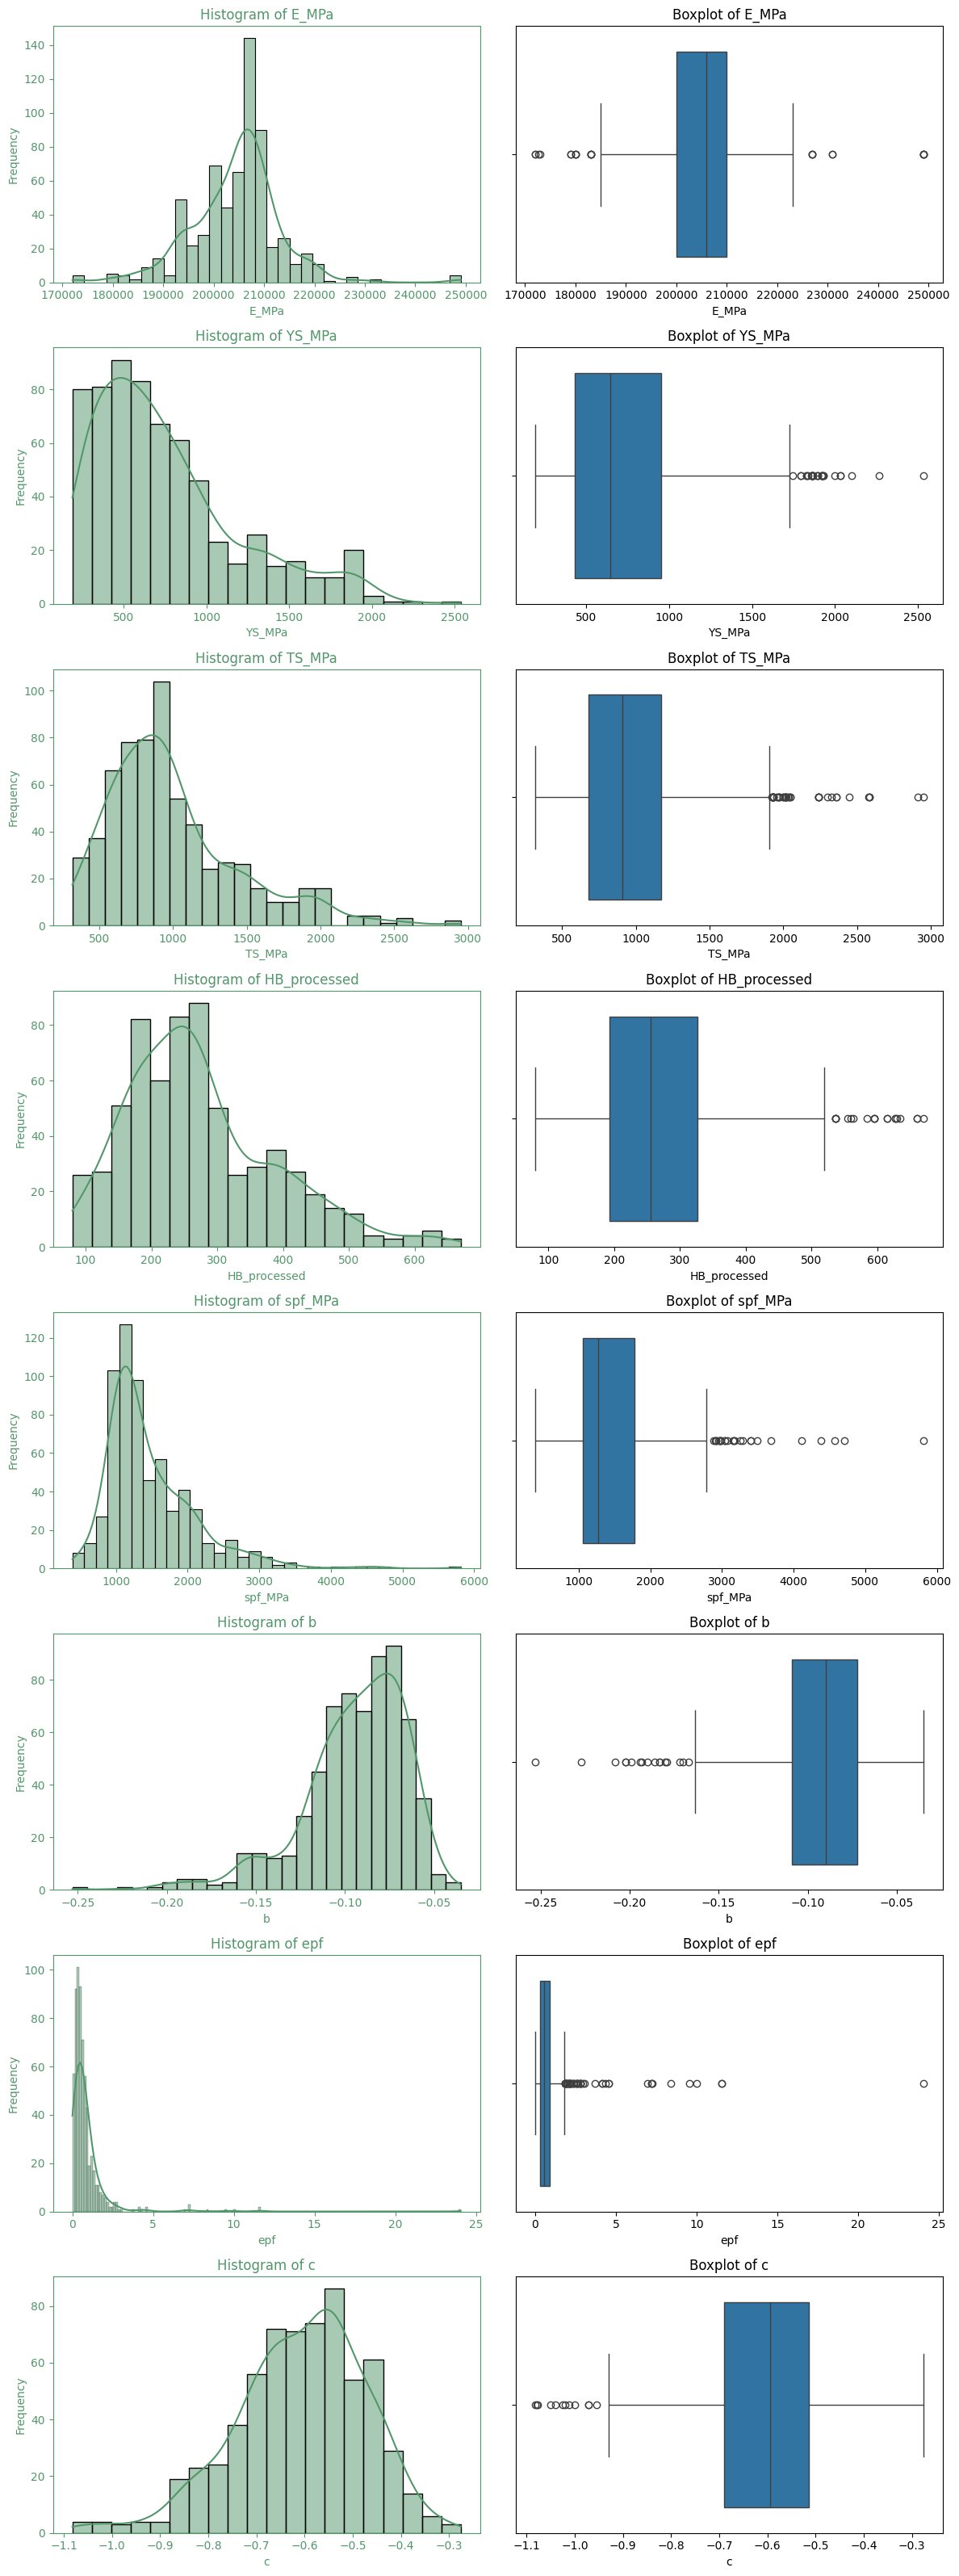

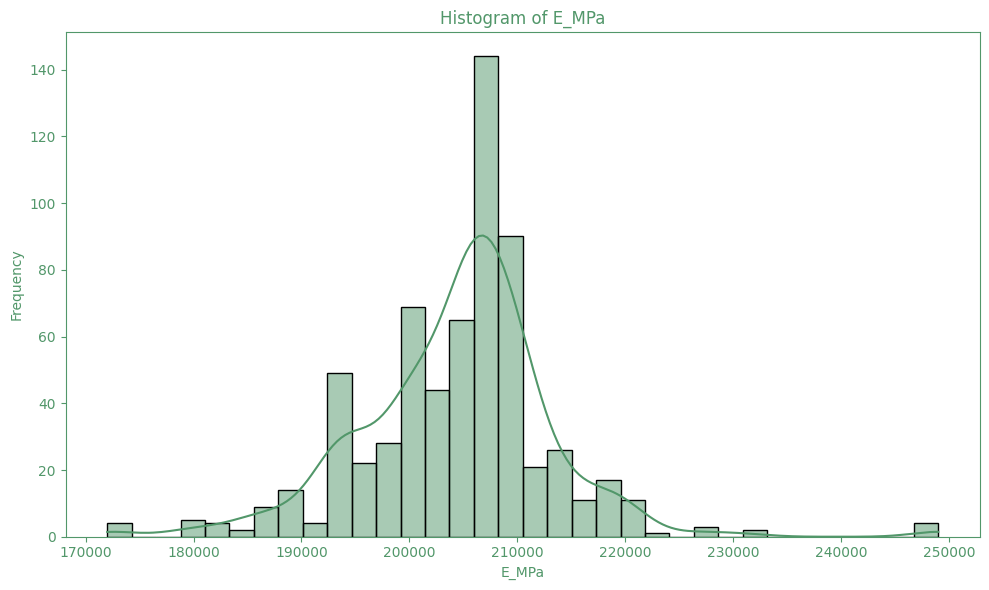


Calculating and Plotting Correlation Matrix...


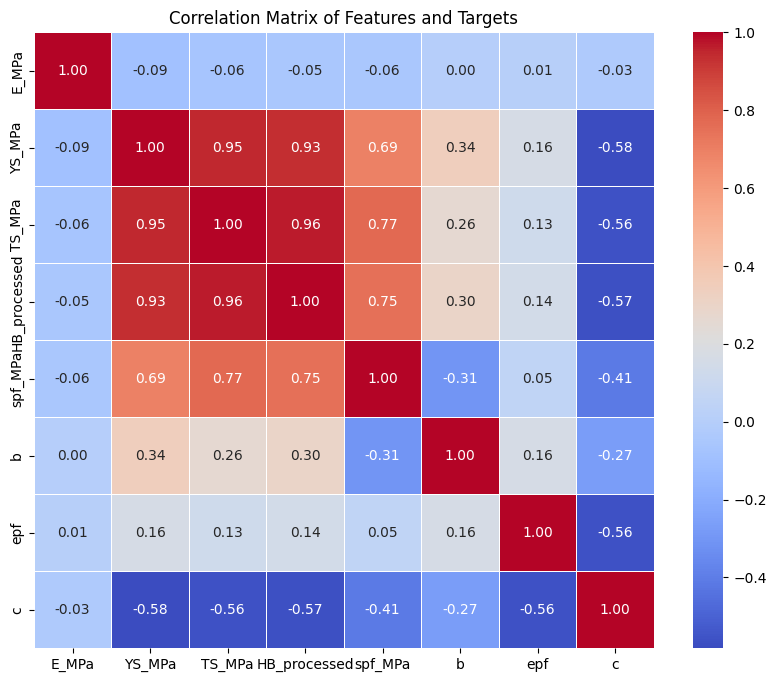


Analysis of target parameters:
Range of 'b': -0.253 -0.035
Range of 'c': -1.082 -0.276
Percentage of non-negative 'b': 0.00%
Percentage of non-negative 'c': 0.00%
Percentage where spf_MPa <= TS_MPa: 1.54%

--- Analysis of Log-Transformed epf ---

Descriptive Statistics (Log-Transformed epf):
count    649.000000
mean       0.506565
std        0.384387
min        0.000570
25%        0.263133
50%        0.425268
75%        0.647627
max        3.220834
Name: epf, dtype: float64


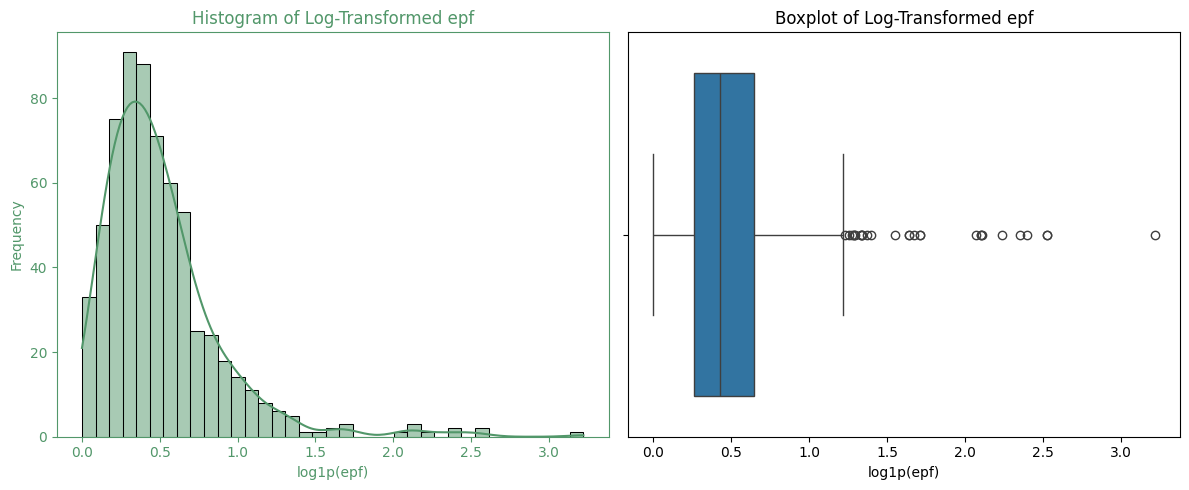

In [5]:
# Cell 5: 탐색적 데이터 분석 (EDA) - 큰 변경 없음, HB_imputed_flag_col 관련 부분 제거

print("\n--- Exploratory Data Analysis ---")

if len(df) > 0: # 데이터가 남아있는 경우에만 EDA 수행
    # 1. Descriptive Statistics
    print("\nDescriptive Statistics (Features and Targets):")
    print(df[feature_cols + target_cols].describe())

    # 2. Distributions
    print("\nPlotting Distributions...")
    n_features = len(feature_cols)
    n_targets = len(target_cols)
    # figure 크기 동적 조절
    fig_height = max(4 * (n_features + n_targets), 12)
    fig, axes = plt.subplots(n_features + n_targets, 2, figsize=(12, fig_height), facecolor='none')

    if n_features + n_targets == 1: # 축 객체가 1차원 배열인 경우 처리
        axes = np.array([axes])
        
    # custom color 정의
    custom_color = (82/255, 151/255, 106/255)  # RGB 값

    for i, col in enumerate(feature_cols + target_cols):
        if col in df.columns: # 컬럼 존재 확인
             # 1열(히스토그램)에 custom color 적용
             sns.histplot(df[col], kde=True, ax=axes[i, 0], color=custom_color)
             axes[i, 0].set_title(f'Histogram of {col}', color=custom_color)
             axes[i, 0].set_xlabel(col, color=custom_color)
             axes[i, 0].set_ylabel('Frequency', color=custom_color)
             axes[i, 0].tick_params(axis='x', colors=custom_color)
             axes[i, 0].tick_params(axis='y', colors=custom_color)
             axes[i, 0].spines['bottom'].set_color(custom_color)
             axes[i, 0].spines['top'].set_color(custom_color)
             axes[i, 0].spines['left'].set_color(custom_color)
             axes[i, 0].spines['right'].set_color(custom_color)
             axes[i, 0].set_facecolor('none')  # 배경 투명하게 설정
             
             # 2열(박스플롯)은 기본 색상 유지
             sns.boxplot(x=df[col], ax=axes[i, 1])
             axes[i, 1].set_title(f'Boxplot of {col}')
             axes[i, 1].set_facecolor('none')  # 배경 투명하게 설정

    plt.tight_layout()
    plt.show()
    
    # custom color 그래프 추가 (첫 번째 컬럼만)
    if len(feature_cols) > 0:
        custom_color = (82/255, 151/255, 106/255)  # RGB 값
        first_col = feature_cols[0]
        
        fig, ax = plt.subplots(figsize=(10, 6), facecolor='none')  # 배경 투명하게 설정
        sns.histplot(df[first_col], kde=True, ax=ax, color=custom_color)
        
        # 모든 요소를 custom color로 설정
        ax.set_title(f'Histogram of {first_col}', color=custom_color)
        ax.set_xlabel(first_col, color=custom_color)
        ax.set_ylabel('Frequency', color=custom_color)
        ax.tick_params(axis='x', colors=custom_color)
        ax.tick_params(axis='y', colors=custom_color)
        ax.spines['bottom'].set_color(custom_color)
        ax.spines['top'].set_color(custom_color)
        ax.spines['left'].set_color(custom_color)
        ax.spines['right'].set_color(custom_color)
        ax.set_facecolor('none')  # 배경 투명하게 설정
        
        plt.tight_layout()
        plt.show()

    # 3. Correlation Matrix
    print("\nCalculating and Plotting Correlation Matrix...")
    # 상관관계 계산 전, 수치형 데이터만 있는지 확인
    numeric_df_for_corr = df[feature_cols + target_cols].select_dtypes(include=np.number)
    if not numeric_df_for_corr.empty:
        correlation_matrix = numeric_df_for_corr.corr()
        plt.figure(figsize=(10, 8), facecolor='none')  # 배경 투명하게 설정
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
        plt.title('Correlation Matrix of Features and Targets')
        plt.gca().set_facecolor('none')  # 히트맵 배경 투명하게 설정
        plt.show()
    else:
        print("No numeric columns found for correlation analysis.")


    # 4. Pair Plots (optional)
    # ...

    # 5. Analysis of Target Parameters (Physical Plausibility)
    print("\nAnalysis of target parameters:")
    if 'b' in df.columns: print("Range of 'b':", df['b'].min(), df['b'].max())
    if 'c' in df.columns: print("Range of 'c':", df['c'].min(), df['c'].max())
    if 'b' in df.columns: print(f"Percentage of non-negative 'b': { (df['b'] >= 0).mean() * 100:.2f}%")
    if 'c' in df.columns: print(f"Percentage of non-negative 'c': { (df['c'] >= 0).mean() * 100:.2f}%")
    if 'spf_MPa' in df.columns and 'TS_MPa' in df.columns:
         print(f"Percentage where spf_MPa <= TS_MPa: { (df['spf_MPa'] <= df['TS_MPa']).mean() * 100:.2f}%")

    # HB imputation status 비교 제거 (HB_imputed_flag_col 없음)
    
    print("\n--- Analysis of Log-Transformed epf ---")
    if 'epf' in target_cols:
        epf_original_values = df['epf'].copy() # 원본 epf 값 사용 (결측치 제거 후)
        epf_log_transformed = np.log1p(np.maximum(epf_original_values, 1e-10))

        print("\nDescriptive Statistics (Log-Transformed epf):")
        print(pd.Series(epf_log_transformed).describe())

        custom_color = (82/255, 151/255, 106/255)  # RGB 값
        fig, axes = plt.subplots(1, 2, figsize=(12, 5), facecolor='none')
        
        # 히스토그램에 custom color 적용
        sns.histplot(epf_log_transformed, kde=True, ax=axes[0], color=custom_color)
        axes[0].set_title('Histogram of Log-Transformed epf', color=custom_color)
        axes[0].set_xlabel('log1p(epf)', color=custom_color)
        axes[0].set_ylabel('Frequency', color=custom_color)
        axes[0].tick_params(axis='x', colors=custom_color)
        axes[0].tick_params(axis='y', colors=custom_color)
        axes[0].spines['bottom'].set_color(custom_color)
        axes[0].spines['top'].set_color(custom_color)
        axes[0].spines['left'].set_color(custom_color)
        axes[0].spines['right'].set_color(custom_color)
        axes[0].set_facecolor('none')  # 배경 투명하게 설정

        # 박스플롯은 기본 색상 유지
        sns.boxplot(x=epf_log_transformed, ax=axes[1])
        axes[1].set_title('Boxplot of Log-Transformed epf')
        axes[1].set_xlabel('log1p(epf)')
        axes[1].set_facecolor('none')  # 배경 투명하게 설정
        
        plt.tight_layout()
        plt.show()
    else:
        print("epf column not found in target_cols for log-transformed analysis.")

else:
    print("\nNo data available for EDA after preprocessing.")


In [6]:
# Cell 6: 데이터 준비 (PyTorch용) - df 사용 확인

print("\n--- Preparing Data for PyTorch (Tensile Model) ---")

if len(df) > 0:
    # Select final features (X) and targets (y) for tensile model
    X = df[feature_cols].values
    y = df[target_cols].values
    # E_MPa 컬럼이 있는지 확인 후 추출
    if 'E_MPa' in df.columns:
        E_for_loss = df['E_MPa'].values
        print(f"E for loss shape: {E_for_loss.shape}")
    else:
        print("Warning: E_MPa column not found. Cannot extract E for physics loss calculation.")
        E_for_loss = np.zeros(len(df)) # 임시값 또는 다른 처리 필요

    print(f"Features shape (X): {X.shape}")
    print(f"Targets shape (y): {y.shape}")

    # 1. Train-Validation-Test Split
    X_train_val, X_test, y_train_val, y_test, E_train_val, E_test = train_test_split(
        X, y, E_for_loss, test_size=0.15, random_state=seed)
    X_train, X_val, y_train, y_val, E_train, E_val = train_test_split(
        X_train_val, y_train_val, E_train_val, test_size=0.1765, random_state=seed) # 0.1765 * 0.85 ≈ 0.15

    print(f"Train set size: {X_train.shape[0]}")
    print(f"Validation set size: {X_val.shape[0]}")
    print(f"Test set size: {X_test.shape[0]}")

    # 2. Scaling
    # scaler_X는 기존과 동일
    scaler_X = StandardScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_val_scaled = scaler_X.transform(X_val)
    X_test_scaled = scaler_X.transform(X_test)

    # --- 개별 타겟 스케일링 및 epf 로그 변환 ---
    target_cols_idx = {name: idx for idx, name in enumerate(target_cols)}
    epf_idx = target_cols_idx.get('epf', -1)

    y_train_transformed = y_train.copy()
    y_val_transformed = y_val.copy()
    y_test_transformed = y_test.copy()

    if epf_idx != -1:
        print(f"epf 컬럼 (인덱스 {epf_idx})에 np.log1p 변환을 적용합니다.")
        # 0 또는 음수 값 방지를 위해 np.maximum 사용
        y_train_transformed[:, epf_idx] = np.log1p(np.maximum(y_train_transformed[:, epf_idx], 1e-10))
        y_val_transformed[:, epf_idx] = np.log1p(np.maximum(y_val_transformed[:, epf_idx], 1e-10))
        y_test_transformed[:, epf_idx] = np.log1p(np.maximum(y_test_transformed[:, epf_idx], 1e-10))
        
        # 로그 변환 적용 확인
        print("\n--- 로그 변환 적용 확인 ---")
        print(f"Train 데이터 epf 로그 변환 전/후 (처음 3개 샘플):")
        for i in range(min(3, len(y_train))):
            print(f"  샘플 {i+1}: {y_train[i, epf_idx]:.6f} -> {y_train_transformed[i, epf_idx]:.6f}")
        
        print(f"\nValidation 데이터 epf 로그 변환 전/후 (처음 3개 샘플):")
        for i in range(min(3, len(y_val))):
            print(f"  샘플 {i+1}: {y_val[i, epf_idx]:.6f} -> {y_val_transformed[i, epf_idx]:.6f}")
            
        print(f"\nTest 데이터 epf 로그 변환 전/후 (처음 3개 샘플):")
        for i in range(min(3, len(y_test))):
            print(f"  샘플 {i+1}: {y_test[i, epf_idx]:.6f} -> {y_test_transformed[i, epf_idx]:.6f}")
        
        # 통계적 확인
        print("\n로그 변환 전/후 통계 비교:")
        print(f"Train 데이터 - 원본 epf: 평균={np.mean(y_train[:, epf_idx]):.4f}, 표준편차={np.std(y_train[:, epf_idx]):.4f}")
        print(f"Train 데이터 - 변환 epf: 평균={np.mean(y_train_transformed[:, epf_idx]):.4f}, 표준편차={np.std(y_train_transformed[:, epf_idx]):.4f}")
        
        print(f"  epf 로그 변환 전/후 (train 예시): [{y_train[0, epf_idx]:.6f}] -> [{y_train_transformed[0, epf_idx]:.6f}]")

    scalers_y = {} # 각 타겟별 스케일러 저장용 딕셔너리
    y_train_scaled = np.zeros_like(y_train_transformed)
    y_val_scaled = np.zeros_like(y_val_transformed)
    y_test_scaled = np.zeros_like(y_test_transformed)

    for i, col_name in enumerate(target_cols):
        scalers_y[col_name] = StandardScaler()
        print(f"Target '{col_name}' will be scaled using StandardScaler.")
            
        y_train_scaled[:, i] = scalers_y[col_name].fit_transform(y_train_transformed[:, i].reshape(-1, 1)).flatten()
        y_val_scaled[:, i] = scalers_y[col_name].transform(y_val_transformed[:, i].reshape(-1, 1)).flatten()
        y_test_scaled[:, i] = scalers_y[col_name].transform(y_test_transformed[:, i].reshape(-1, 1)).flatten()
        
    # 개별 스케일러 적용 확인
    print("\n--- 개별 스케일러 적용 확인 ---")
    for i, col_name in enumerate(target_cols):
        print(f"\n{col_name} 스케일링 확인 ({type(scalers_y[col_name]).__name__} 사용):") # 사용된 스케일러 타입 명시
        print(f"  변환된 데이터 (스케일링 전) - 평균: {np.mean(y_train_transformed[:, i]):.6f}, 표준편차: {np.std(y_train_transformed[:, i]):.6f}")
        print(f"  스케일링된 데이터 - 평균: {np.mean(y_train_scaled[:, i]):.6f}, 표준편차: {np.std(y_train_scaled[:, i]):.6f}")
        
        print(f"  샘플 데이터 비교 (처음 3개):")
        for j in range(min(3, len(y_train))):
            print(f"    샘플 {j+1}: {y_train_transformed[j, i]:.6f} -> {y_train_scaled[j, i]:.6f}")
            
        if col_name == 'epf':
            print(f"  epf 로그변환 후 {type(scalers_y[col_name]).__name__} 스케일링 확인:") # 스케일러 타입 명시
            orig_epf = y_train[0, i]
            log_epf = y_train_transformed[0, i]
            scaled_epf = y_train_scaled[0, i]
            print(f"    원본 -> 로그변환 -> 스케일링: {orig_epf:.6f} -> {log_epf:.6f} -> {scaled_epf:.6f}")
            
            direct_scaled = scalers_y['epf'].transform(np.array([log_epf]).reshape(-1, 1))[0][0]
            print(f"    스케일러 직접 적용 결과: {direct_scaled:.6f} (스케일링된 값과 일치해야 함)")

    # 역변환 함수 정의 (개별 스케일러 및 epf 로그 역변환 고려)
    def inverse_transform_targets(y_scaled_data, scalers_y_dict, target_cols_list):
        # y_scaled_data가 1차원 배열일 경우 (예: 단일 샘플 예측) 2차원으로 변환
        if y_scaled_data.ndim == 1:
            y_scaled_data = y_scaled_data.reshape(1, -1)
            
        y_transformed_individually = np.zeros_like(y_scaled_data)
        for i, col_name in enumerate(target_cols_list):
            # 각 컬럼에 해당하는 스케일러로 역변환
            y_transformed_individually[:, i] = scalers_y_dict[col_name].inverse_transform(y_scaled_data[:, i].reshape(-1, 1)).flatten()
        
        y_orig_scale = y_transformed_individually.copy()
        
        current_epf_idx = -1
        if 'epf' in target_cols_list:
            current_epf_idx = target_cols_list.index('epf')
            
        if current_epf_idx != -1:
            # expm1을 사용하여 로그 변환 역변환
            y_orig_scale[:, current_epf_idx] = np.expm1(y_transformed_individually[:, current_epf_idx])
            print(f"epf (index {current_epf_idx}) 역변환 (np.expm1) applied.")
        
        # 만약 원래 y_scaled_data가 1차원이었다면, 결과도 1차원으로 반환
        if y_scaled_data.shape[0] == 1 and y_orig_scale.shape[0] == 1:
             return y_orig_scale.flatten()
        return y_orig_scale

    joblib.dump(scaler_X, 'scaler_X.pkl')
    joblib.dump(scalers_y, 'scalers_y.pkl') # 스케일러 딕셔너리 저장
    print("Features scaled. Feature scaler (scaler_X.pkl) and target scalers dictionary (scalers_y.pkl) saved.")

    # 3. Create PyTorch Datasets and DataLoaders
    batch_size = 16

    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
    E_train_tensor = torch.tensor(E_train, dtype=torch.float32).unsqueeze(1)

    X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val_scaled, dtype=torch.float32)
    E_val_tensor = torch.tensor(E_val, dtype=torch.float32).unsqueeze(1)

    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32) # 스케일링된 y_test 사용
    E_test_tensor = torch.tensor(E_test, dtype=torch.float32).unsqueeze(1)
    # y_test_orig_tensor는 원본 y_test (로그 변환 전, 스케일링 전) 값을 사용해야 합니다.
    y_test_orig_tensor = torch.tensor(y_test, dtype=torch.float32)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor, E_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor, E_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor, E_test_tensor, y_test_orig_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    print("PyTorch Datasets and DataLoaders created for tensile model.")
    print(f"Number of training batches: {len(train_loader)}")
    print(f"Number of validation batches: {len(val_loader)}")
    print(f"Number of test batches: {len(test_loader)}")

else:
    print("\nNo data available for PyTorch preparation.")


--- Preparing Data for PyTorch (Tensile Model) ---
E for loss shape: (649,)
Features shape (X): (649, 4)
Targets shape (y): (649, 4)
Train set size: 453
Validation set size: 98
Test set size: 98
epf 컬럼 (인덱스 2)에 np.log1p 변환을 적용합니다.

--- 로그 변환 적용 확인 ---
Train 데이터 epf 로그 변환 전/후 (처음 3개 샘플):
  샘플 1: 0.626000 -> 0.486123
  샘플 2: 1.135900 -> 0.758888
  샘플 3: 0.705100 -> 0.533624

Validation 데이터 epf 로그 변환 전/후 (처음 3개 샘플):
  샘플 1: 0.243000 -> 0.217528
  샘플 2: 0.860000 -> 0.620576
  샘플 3: 0.600000 -> 0.470004

Test 데이터 epf 로그 변환 전/후 (처음 3개 샘플):
  샘플 1: 0.210000 -> 0.190620
  샘플 2: 0.963000 -> 0.674474
  샘플 3: 0.553300 -> 0.440382

로그 변환 전/후 통계 비교:
Train 데이터 - 원본 epf: 평균=0.8395, 표준편차=1.5262
Train 데이터 - 변환 epf: 평균=0.5029, 표준편차=0.3802
  epf 로그 변환 전/후 (train 예시): [0.626000] -> [0.486123]
Target 'spf_MPa' will be scaled using StandardScaler.
Target 'b' will be scaled using StandardScaler.
Target 'epf' will be scaled using StandardScaler.
Target 'c' will be scaled using StandardScaler.

--- 개별 스케일러 적용

In [7]:
# Cell 7: PINN 모델 정의 (FatiguePINN) - 드롭아웃 추가, [128, 256, 128] 구조

if len(df) > 0:
    class FatiguePINN(nn.Module):
        def __init__(self, input_dim, output_dim, hidden_dims=[128, 256, 128], dropout_p=0.2): 
            super().__init__()
            self.input_dim = input_dim
            self.output_dim = output_dim

            layers = []
            last_dim = input_dim
            for hidden_dim in hidden_dims: # 인자로 받은 hidden_dims를 사용
                layers.append(nn.Linear(last_dim, hidden_dim))
                layers.append(nn.ReLU())
                layers.append(nn.Dropout(dropout_p))  # 드롭아웃 레이어 추가
                last_dim = hidden_dim
            
            layers.append(nn.Linear(last_dim, output_dim)) # 최종 출력 레이어
            self.network = nn.Sequential(*layers)

        def forward(self, x):
            return self.network(x)

    # 모델 인스턴스화
    input_dim = X_train_scaled.shape[1] if 'X_train_scaled' in locals() else 4 
    output_dim = y_train_scaled.shape[1] if 'y_train_scaled' in locals() else 4 
    
    # --- 은닉층 구조 설정 ---
    hidden_dims_target = [128, 256, 128] # 목표하는 은닉층 구조 (3개 층)
    dropout_rate = 0.1  # 드롭아웃 비율 설정
    
    # 모델 생성 시 hidden_dims_target와 dropout_p를 전달합니다.
    model = FatiguePINN(input_dim, output_dim, hidden_dims=hidden_dims_target, dropout_p=dropout_rate).to(device)

    print(f"PINN Model Definition (FatiguePINN with hidden_dims={hidden_dims_target}, dropout_p={dropout_rate}):")
    print(model) 

    # 더미 테스트
    try:
        batch_size_local = batch_size if 'batch_size' in locals() else 16
        dummy_input = torch.randn(batch_size_local, input_dim).to(device)
        dummy_output = model(dummy_input)
        print(f"\nDummy input shape: {dummy_input.shape}")
        print(f"Dummy output shape: {dummy_output.shape}")
    except Exception as e:
        print(f"\nCould not perform dummy test: {e}")
else:
    print("\nSkipping model definition as no data is available.")

PINN Model Definition (FatiguePINN with hidden_dims=[128, 256, 128], dropout_p=0.1):
FatiguePINN(
  (network): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=128, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.1, inplace=False)
    (9): Linear(in_features=128, out_features=4, bias=True)
  )
)

Dummy input shape: torch.Size([16, 4])
Dummy output shape: torch.Size([16, 4])


In [8]:
# Cell 8: 손실 함수 정의 (PINN) - lambda_physics_value 수정

if len(df) > 0:
    def pinn_loss_function(model_outputs_scaled, targets_scaled, E_unscaled,
                           scalers_y_dict, target_cols_list,  # 수정된 부분
                           lambda_physics, # 기본값 제거
                           epf_loss_weight, # 새로운 인자 추가
                           num_physics_points=20, 
                           Nf_min=1e1, Nf_max=1e7, device='cpu'):
        """
        Calculates the combined Data and Physics loss for the Fatigue PINN.
        (Function definition remains the same as provided previously)
        """
        # 1. Data Loss (MSE on scaled parameters)
        data_loss_fn = nn.MSELoss()
        
        data_loss_components = []
        # epf_loss_weight 인자로 받아 사용

        for i, col_name in enumerate(target_cols_list):
            # 각 타겟별로 MSE 손실 계산
            loss_per_target = data_loss_fn(model_outputs_scaled[:, i], targets_scaled[:, i])
            
            if col_name == 'epf':
                data_loss_components.append(epf_loss_weight * loss_per_target)
                print(f"DEBUG: epf_loss (weighted by {epf_loss_weight}): {epf_loss_weight * loss_per_target.item():.4f}, original_epf_loss: {loss_per_target.item():.4f}") # 디버깅용
            else:
                data_loss_components.append(loss_per_target)
                # print(f"DEBUG: {col_name}_loss: {loss_per_target.item():.4f}") # 다른 타겟 디버깅용 (선택적)

        # 모든 타겟 손실 요소들의 합계를 구함
        data_loss = torch.stack(data_loss_components).sum() 
        # 또는 평균을 사용할 수도 있습니다. sum()이 더 직접적으로 epf 가중치를 반영합니다.
        # data_loss = torch.stack(data_loss_components).mean() 

        # 2. Physics Loss (Coffin-Manson)
        physics_loss = torch.tensor(0.0, device=device) # 기본값 초기화
        try:
            # Inverse transform the *predicted* parameters with our custom function
            batch_size = model_outputs_scaled.shape[0]
            
            # 예측값 역변환
            model_outputs_scaled_np = model_outputs_scaled.detach().cpu().numpy()
            model_outputs_unscaled_np = np.zeros_like(model_outputs_scaled_np)

            for i, col_name in enumerate(target_cols_list):
                model_outputs_unscaled_np[:, i] = scalers_y_dict[col_name].inverse_transform(model_outputs_scaled_np[:, i].reshape(-1, 1)).flatten()

            if 'epf' in target_cols_list:
                epf_idx_dynamic = target_cols_list.index('epf')
                model_outputs_unscaled_np[:, epf_idx_dynamic] = np.expm1(model_outputs_unscaled_np[:, epf_idx_dynamic])

            model_outputs_unscaled = torch.tensor(model_outputs_unscaled_np, dtype=torch.float32).to(device)

            # 동적 인덱스 추출
            spf_pred_idx = target_cols_list.index('spf_MPa')
            b_pred_idx = target_cols_list.index('b')
            epf_pred_idx = target_cols_list.index('epf')
            c_pred_idx = target_cols_list.index('c')

            spf_pred = model_outputs_unscaled[:, spf_pred_idx].unsqueeze(1)
            b_pred = model_outputs_unscaled[:, b_pred_idx].unsqueeze(1)
            epf_pred = model_outputs_unscaled[:, epf_pred_idx].unsqueeze(1)
            c_pred = model_outputs_unscaled[:, c_pred_idx].unsqueeze(1)

            reversals = torch.logspace(torch.log10(torch.tensor(Nf_min)), torch.log10(torch.tensor(Nf_max)), num_physics_points).unsqueeze(0).to(device)

            # Avoid division by zero or invalid E
            E_unscaled_safe = torch.where(E_unscaled <= 0, torch.tensor(1e-6, device=device), E_unscaled)

            epsilon_a_pred = (spf_pred / E_unscaled_safe) * (reversals ** b_pred) + epf_pred * (reversals ** c_pred)

            # 실제값 역변환
            targets_scaled_np = targets_scaled.detach().cpu().numpy()
            targets_unscaled_np = np.zeros_like(targets_scaled_np)

            for i, col_name in enumerate(target_cols_list):
                targets_unscaled_np[:, i] = scalers_y_dict[col_name].inverse_transform(targets_scaled_np[:, i].reshape(-1, 1)).flatten()

            if 'epf' in target_cols_list:
                epf_idx_dynamic = target_cols_list.index('epf')
                targets_unscaled_np[:, epf_idx_dynamic] = np.expm1(targets_unscaled_np[:, epf_idx_dynamic])

            targets_unscaled = torch.tensor(targets_unscaled_np, dtype=torch.float32).to(device)
            
            spf_true = targets_unscaled[:, spf_pred_idx].unsqueeze(1)
            b_true = targets_unscaled[:, b_pred_idx].unsqueeze(1)
            epf_true = targets_unscaled[:, epf_pred_idx].unsqueeze(1)
            c_true = targets_unscaled[:, c_pred_idx].unsqueeze(1)
            
            epsilon_a_true = (spf_true / E_unscaled_safe) * (reversals ** b_true) + epf_true * (reversals ** c_true)

            physics_loss = torch.mean((epsilon_a_pred - epsilon_a_true)**2)

            # Handle potential NaN in physics loss (e.g., from large exponents)
            if torch.isnan(physics_loss):
                 physics_loss = torch.tensor(0.0, device=device)

        except KeyError as e:
            print(f"Warning: KeyError in physics loss calculation: {e}. Setting physics loss to 0 for this batch.")
            physics_loss = torch.tensor(0.0, device=device)
        except Exception as e:
            print(f"Warning: Error calculating physics loss: {e}. Setting physics loss to 0 for this batch.")
            physics_loss = torch.tensor(0.0, device=device)


        # 3. Total Loss
        total_loss = data_loss + lambda_physics * physics_loss

        return total_loss, data_loss, physics_loss

    # --- Test the loss function ---
    try:
        sample_X, sample_y_scaled, sample_E = next(iter(train_loader))
        sample_X, sample_y_scaled, sample_E = sample_X.to(device), sample_y_scaled.to(device), sample_E.to(device)

        model.eval()
        with torch.no_grad():
             sample_output_scaled = model(sample_X)

        # --- lambda_physics_value와 epf_loss_weight 테스트 값 설정 ---
        lambda_physics_value = 0.1 # 테스트 및 튜닝용 람다 값
        epf_loss_weight_value = 1.5 # 테스트 및 튜닝용 epf 가중치 값
        
        total_loss, data_loss, physics_loss = pinn_loss_function(
            sample_output_scaled, sample_y_scaled, sample_E, 
            scalers_y, target_cols,  # 수정된 부분
            lambda_physics=lambda_physics_value,
            epf_loss_weight=epf_loss_weight_value,
            device=device
        )

        print(f"\nTesting Loss Function (lambda_physics = {lambda_physics_value}, epf_loss_weight = {epf_loss_weight_value}):") # 변경된 값 출력
        print(f"  Sample Output (scaled) shape: {sample_output_scaled.shape}")
        print(f"  Sample Target (scaled) shape: {sample_y_scaled.shape}")
        print(f"  Sample E (unscaled) shape: {sample_E.shape}")
        print(f"  Calculated Total Loss: {total_loss.item():.4f}")
        print(f"  Calculated Data Loss: {data_loss.item():.4f}")
        print(f"  Calculated Physics Loss: {physics_loss.item():.4f}") # 이 값은 lambda_physics가 곱해지기 전의 값입니다.
        print(f"  Weighted Physics Loss (in Total Loss): {(lambda_physics_value * physics_loss.item()):.4f}")

    except StopIteration:
        print(f"\n데이터 로더가 비어 있어 손실 함수를 테스트할 수 없습니다.")
        lambda_physics_value = 0.1
        epf_loss_weight_value = 1.5
        print(f"기본값 lambda_physics_value = {lambda_physics_value}, epf_loss_weight_value = {epf_loss_weight_value}를 사용합니다.")
    except Exception as e:
        print(f"\nCould not test loss function, likely due to data loader issue: {e}")
        # --- 기본값 설정 ---
        lambda_physics_value = 0.1 # 기본값 설정
        epf_loss_weight_value = 1.5 # 기본값 설정
        print(f"Using default lambda_physics_value = {lambda_physics_value}, epf_loss_weight_value = {epf_loss_weight_value}")


else:
    print("\nSkipping loss function definition and testing.")
    # --- 기본값 설정 ---
    lambda_physics_value = 0.1 # 기본값
    epf_loss_weight_value = 1.5 # 기본값
    print(f"Using default lambda_physics_value = {lambda_physics_value}, epf_loss_weight_value = {epf_loss_weight_value} as no data is available.")

DEBUG: epf_loss (weighted by 1.5): 1.0612, original_epf_loss: 0.7075

Testing Loss Function (lambda_physics = 0.1, epf_loss_weight = 1.5):
  Sample Output (scaled) shape: torch.Size([16, 4])
  Sample Target (scaled) shape: torch.Size([16, 4])
  Sample E (unscaled) shape: torch.Size([16, 1])
  Calculated Total Loss: 2.7992
  Calculated Data Loss: 2.7991
  Calculated Physics Loss: 0.0008
  Weighted Physics Loss (in Total Loss): 0.0001


In [9]:
# Cell 8.5: Optuna Objective 함수 정의
def objective(trial):
    # --- 하이퍼파라미터 제안 ---
    # 1. 모델 구조
    n_layers = trial.suggest_int('n_layers', 1, 4) # 은닉층 수 (1~4개 시도)
    hidden_dims = []
    for i in range(n_layers):
        hidden_dims.append(trial.suggest_int(f'n_units_l{i}', 64, 384, step=32)) # 뉴런 수 (64~384)
    dropout_p = trial.suggest_float('dropout_p', 0.0, 0.5, step=0.05)

    # 2. 학습 파라미터
    learning_rate = trial.suggest_float('learning_rate', 5e-5, 5e-3, log=True)
    # batch_size = trial.suggest_categorical('batch_size', [16, 32]) # 필요시

    # 3. 손실 함수 가중치 (Cell 8에서 수정한 pinn_loss_function 인자에 맞춰서)
    epf_weight_objective = trial.suggest_float('epf_loss_weight', 1.0, 20.0, log=True) # epf 손실 가중치 (1~20)
    lambda_physics_objective = trial.suggest_float('lambda_physics', 1e-3, 0.5, log=True) # 물리 손실 가중치

    # --- 모델 생성 (Cell 7 내용 기반) ---
    # input_dim, output_dim은 objective 함수 외부에서 접근 가능해야 함
    # (Cell 7 실행 후 이 값들이 전역 변수로 존재한다고 가정)
    if 'input_dim' not in globals() or 'output_dim' not in globals():
         # Cell 7을 먼저 실행하여 input_dim, output_dim을 설정해야 합니다.
        current_X_train_scaled = X_train_scaled # Cell 6에서 정의됨
        current_y_train_scaled = y_train_scaled # Cell 6에서 정의됨
        temp_input_dim = current_X_train_scaled.shape[1]
        temp_output_dim = current_y_train_scaled.shape[1]
        print(f"Warning: input_dim/output_dim not found. Using {temp_input_dim}/{temp_output_dim}")
    else:
        temp_input_dim = input_dim
        temp_output_dim = output_dim
        
    model_opt = FatiguePINN(temp_input_dim, temp_output_dim, hidden_dims=hidden_dims, dropout_p=dropout_p).to(device)
    optimizer_opt = torch.optim.Adam(model_opt.parameters(), lr=learning_rate)

    # --- 학습 루프 (Cell 9 내용 기반, 축약 버전) ---
    epochs_objective = 100  # Optuna trial당 epoch 수 (시간을 고려하여 조절)
    patience_objective = 15 # 조기 종료 patience

    best_val_loss_opt = float('inf')
    epochs_no_improve_opt = 0

    # train_loader, val_loader, scalers_y, target_cols, device는 외부 스코프에서 가져옴
    # (Cell 6 등에서 이미 준비되었다고 가정)

    for epoch in range(epochs_objective):
        model_opt.train()
        # 학습 코드 (Cell 9의 train 루프 부분과 유사하게 작성)
        for batch_X, batch_y_scaled, batch_E in train_loader:
            batch_X, batch_y_scaled, batch_E = batch_X.to(device), batch_y_scaled.to(device), batch_E.to(device)
            outputs_scaled = model_opt(batch_X)
            
            # 수정된 pinn_loss_function 호출
            loss, _, _ = pinn_loss_function(
                outputs_scaled, batch_y_scaled, batch_E,
                scalers_y, target_cols,
                lambda_physics=lambda_physics_objective, # trial에서 제안된 값
                epf_loss_weight=epf_weight_objective,   # trial에서 제안된 값
                device=device
            )
            optimizer_opt.zero_grad()
            loss.backward()
            optimizer_opt.step()

        # 검증 코드 (Cell 9의 validation 루프 부분과 유사하게 작성)
        model_opt.eval()
        val_epoch_loss = 0.0
        with torch.no_grad():
            for batch_X_val, batch_y_val_scaled, batch_E_val in val_loader:
                batch_X_val, batch_y_val_scaled, batch_E_val = batch_X_val.to(device), batch_y_val_scaled.to(device), batch_E_val.to(device)
                outputs_val_scaled = model_opt(batch_X_val)
                val_loss, _, _ = pinn_loss_function(
                    outputs_val_scaled, batch_y_val_scaled, batch_E_val,
                    scalers_y, target_cols,
                    lambda_physics=lambda_physics_objective,
                    epf_loss_weight=epf_weight_objective,
                    device=device
                )
                val_epoch_loss += val_loss.item()
        
        avg_val_loss = val_epoch_loss / len(val_loader)

        # Optuna Pruning (선택적이지만 권장)
        trial.report(avg_val_loss, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

        if avg_val_loss < best_val_loss_opt:
            best_val_loss_opt = avg_val_loss
            epochs_no_improve_opt = 0
        else:
            epochs_no_improve_opt += 1
        
        if epochs_no_improve_opt >= patience_objective:
            break
            
    return best_val_loss_opt # Optuna는 이 값을 최소화하는 것을 목표로 함


<>:6: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
<>:9: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
<>:6: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
<>:9: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
/var/folders/8w/3krsjjds797bmd_c1mcxqq1c0000gn/T/ipykernel_12801/3209602024.py:6: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
  if 'input_dim' not in globals() or 'input_dim' is None: # None 체크 추가
/var/folders/8w/3krsjjds797bmd_c1mcxqq1c0000gn/T/ipykernel_12801/3209602024.py:9: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
  if 'output_dim' not in globals() or 'output_dim' is None: # None 체크 추가
[I 2025-05-21 16:00:02,388] A new study created in memory with name: fatigue_pinn_hpo_v2



--- Starting Optuna HPO for 50 trials (timeout: 7200s) ---
Study Name: fatigue_pinn_hpo_v2
DEBUG: epf_loss (weighted by 3.7515129712977773): 1.8247, original_epf_loss: 0.4864
DEBUG: epf_loss (weighted by 3.7515129712977773): 1.4039, original_epf_loss: 0.3742
DEBUG: epf_loss (weighted by 3.7515129712977773): 1.4197, original_epf_loss: 0.3784
DEBUG: epf_loss (weighted by 3.7515129712977773): 3.5041, original_epf_loss: 0.9340
DEBUG: epf_loss (weighted by 3.7515129712977773): 5.6224, original_epf_loss: 1.4987
DEBUG: epf_loss (weighted by 3.7515129712977773): 1.0786, original_epf_loss: 0.2875
DEBUG: epf_loss (weighted by 3.7515129712977773): 1.8543, original_epf_loss: 0.4943
DEBUG: epf_loss (weighted by 3.7515129712977773): 2.6653, original_epf_loss: 0.7105
DEBUG: epf_loss (weighted by 3.7515129712977773): 1.8975, original_epf_loss: 0.5058
DEBUG: epf_loss (weighted by 3.7515129712977773): 2.5680, original_epf_loss: 0.6845
DEBUG: epf_loss (weighted by 3.7515129712977773): 7.0447, original_e

[I 2025-05-21 16:00:15,380] Trial 0 finished with value: 4.063264080456325 and parameters: {'n_layers': 4, 'n_units_l0': 128, 'n_units_l1': 96, 'n_units_l2': 320, 'n_units_l3': 160, 'dropout_p': 0.35000000000000003, 'learning_rate': 0.0031144962159827326, 'epf_loss_weight': 3.7515129712977773, 'lambda_physics': 0.004202019474484597}. Best is trial 0 with value: 4.063264080456325.


DEBUG: epf_loss (weighted by 3.7515129712977773): 4.5394, original_epf_loss: 1.2100
DEBUG: epf_loss (weighted by 3.7515129712977773): 5.1707, original_epf_loss: 1.3783
DEBUG: epf_loss (weighted by 3.7515129712977773): 7.5505, original_epf_loss: 2.0127
DEBUG: epf_loss (weighted by 3.7515129712977773): 2.0845, original_epf_loss: 0.5556
DEBUG: epf_loss (weighted by 3.7515129712977773): 1.3767, original_epf_loss: 0.3670
DEBUG: epf_loss (weighted by 3.7515129712977773): 1.5402, original_epf_loss: 0.4106
DEBUG: epf_loss (weighted by 3.7515129712977773): 2.1858, original_epf_loss: 0.5827
DEBUG: epf_loss (weighted by 3.7515129712977773): 0.5053, original_epf_loss: 0.1347
DEBUG: epf_loss (weighted by 11.907177181534914): 22.9922, original_epf_loss: 1.9310
DEBUG: epf_loss (weighted by 11.907177181534914): 7.1536, original_epf_loss: 0.6008
DEBUG: epf_loss (weighted by 11.907177181534914): 22.4110, original_epf_loss: 1.8821
DEBUG: epf_loss (weighted by 11.907177181534914): 4.3109, original_epf_los

[I 2025-05-21 16:00:20,881] Trial 1 finished with value: 10.577456610543388 and parameters: {'n_layers': 1, 'n_units_l0': 256, 'dropout_p': 0.15000000000000002, 'learning_rate': 0.0013288498096712667, 'epf_loss_weight': 11.907177181534914, 'lambda_physics': 0.055072124403406836}. Best is trial 0 with value: 4.063264080456325.


DEBUG: epf_loss (weighted by 11.907177181534914): 20.2798, original_epf_loss: 1.7032
DEBUG: epf_loss (weighted by 11.907177181534914): 7.1718, original_epf_loss: 0.6023
DEBUG: epf_loss (weighted by 11.907177181534914): 14.8163, original_epf_loss: 1.2443
DEBUG: epf_loss (weighted by 11.907177181534914): 25.5620, original_epf_loss: 2.1468
DEBUG: epf_loss (weighted by 11.907177181534914): 6.4241, original_epf_loss: 0.5395
DEBUG: epf_loss (weighted by 11.907177181534914): 5.2497, original_epf_loss: 0.4409
DEBUG: epf_loss (weighted by 11.907177181534914): 5.0427, original_epf_loss: 0.4235
DEBUG: epf_loss (weighted by 11.907177181534914): 7.7527, original_epf_loss: 0.6511
DEBUG: epf_loss (weighted by 11.907177181534914): 3.7521, original_epf_loss: 0.3151
DEBUG: epf_loss (weighted by 5.213562803112358): 9.5278, original_epf_loss: 1.8275
DEBUG: epf_loss (weighted by 5.213562803112358): 1.9782, original_epf_loss: 0.3794
DEBUG: epf_loss (weighted by 5.213562803112358): 1.1293, original_epf_loss:

[I 2025-05-21 16:00:32,481] Trial 2 finished with value: 5.241274271692548 and parameters: {'n_layers': 4, 'n_units_l0': 352, 'n_units_l1': 192, 'n_units_l2': 96, 'n_units_l3': 320, 'dropout_p': 0.45, 'learning_rate': 0.0008492498922737908, 'epf_loss_weight': 5.213562803112358, 'lambda_physics': 0.03394549416455581}. Best is trial 0 with value: 4.063264080456325.


DEBUG: epf_loss (weighted by 5.213562803112358): 1.7202, original_epf_loss: 0.3300
DEBUG: epf_loss (weighted by 5.213562803112358): 9.3343, original_epf_loss: 1.7904
DEBUG: epf_loss (weighted by 5.213562803112358): 2.0794, original_epf_loss: 0.3989
DEBUG: epf_loss (weighted by 5.213562803112358): 3.3435, original_epf_loss: 0.6413
DEBUG: epf_loss (weighted by 5.213562803112358): 1.0842, original_epf_loss: 0.2080
DEBUG: epf_loss (weighted by 5.213562803112358): 3.7346, original_epf_loss: 0.7163
DEBUG: epf_loss (weighted by 5.213562803112358): 1.6661, original_epf_loss: 0.3196
DEBUG: epf_loss (weighted by 5.213562803112358): 7.0427, original_epf_loss: 1.3508
DEBUG: epf_loss (weighted by 5.213562803112358): 10.8618, original_epf_loss: 2.0834
DEBUG: epf_loss (weighted by 5.213562803112358): 2.8524, original_epf_loss: 0.5471
DEBUG: epf_loss (weighted by 5.213562803112358): 1.7852, original_epf_loss: 0.3424
DEBUG: epf_loss (weighted by 5.213562803112358): 2.1338, original_epf_loss: 0.4093
DEB

[I 2025-05-21 16:00:51,821] Trial 3 finished with value: 9.95658370426723 and parameters: {'n_layers': 3, 'n_units_l0': 288, 'n_units_l1': 96, 'n_units_l2': 352, 'dropout_p': 0.1, 'learning_rate': 0.002934362533763049, 'epf_loss_weight': 12.094137963284087, 'lambda_physics': 0.31256146116583866}. Best is trial 0 with value: 4.063264080456325.


DEBUG: epf_loss (weighted by 12.094137963284087): 10.5725, original_epf_loss: 0.8742
DEBUG: epf_loss (weighted by 12.094137963284087): 3.8386, original_epf_loss: 0.3174
DEBUG: epf_loss (weighted by 12.094137963284087): 1.6623, original_epf_loss: 0.1374
DEBUG: epf_loss (weighted by 12.094137963284087): 15.7557, original_epf_loss: 1.3028
DEBUG: epf_loss (weighted by 12.094137963284087): 22.6098, original_epf_loss: 1.8695
DEBUG: epf_loss (weighted by 12.094137963284087): 10.9768, original_epf_loss: 0.9076
DEBUG: epf_loss (weighted by 12.094137963284087): 3.2505, original_epf_loss: 0.2688
DEBUG: epf_loss (weighted by 12.094137963284087): 4.1657, original_epf_loss: 0.3444
DEBUG: epf_loss (weighted by 12.094137963284087): 8.1329, original_epf_loss: 0.6725
DEBUG: epf_loss (weighted by 12.094137963284087): 2.0697, original_epf_loss: 0.1711
DEBUG: epf_loss (weighted by 1.1691808336458194): 0.8160, original_epf_loss: 0.6979
DEBUG: epf_loss (weighted by 1.1691808336458194): 0.8540, original_epf_l

[I 2025-05-21 16:01:06,435] Trial 4 finished with value: 2.0420900923865184 and parameters: {'n_layers': 4, 'n_units_l0': 384, 'n_units_l1': 192, 'n_units_l2': 224, 'n_units_l3': 352, 'dropout_p': 0.45, 'learning_rate': 0.0004087551873675731, 'epf_loss_weight': 1.1691808336458194, 'lambda_physics': 0.18169492252951747}. Best is trial 4 with value: 2.0420900923865184.


DEBUG: epf_loss (weighted by 1.1691808336458194): 0.7685, original_epf_loss: 0.6573
DEBUG: epf_loss (weighted by 1.1691808336458194): 0.5461, original_epf_loss: 0.4671
DEBUG: epf_loss (weighted by 1.1691808336458194): 0.6729, original_epf_loss: 0.5755
DEBUG: epf_loss (weighted by 1.1691808336458194): 2.1060, original_epf_loss: 1.8013
DEBUG: epf_loss (weighted by 1.1691808336458194): 0.5415, original_epf_loss: 0.4632
DEBUG: epf_loss (weighted by 1.1691808336458194): 3.6209, original_epf_loss: 3.0969
DEBUG: epf_loss (weighted by 1.1691808336458194): 0.6336, original_epf_loss: 0.5419
DEBUG: epf_loss (weighted by 1.1691808336458194): 2.2625, original_epf_loss: 1.9351
DEBUG: epf_loss (weighted by 1.1691808336458194): 0.8438, original_epf_loss: 0.7217
DEBUG: epf_loss (weighted by 1.1691808336458194): 0.3239, original_epf_loss: 0.2771
DEBUG: epf_loss (weighted by 1.1691808336458194): 3.1344, original_epf_loss: 2.6809
DEBUG: epf_loss (weighted by 1.1691808336458194): 1.3368, original_epf_loss:

[I 2025-05-21 16:01:14,694] Trial 5 pruned. 


DEBUG: epf_loss (weighted by 6.15404827234468): 12.1950, original_epf_loss: 1.9816
DEBUG: epf_loss (weighted by 6.15404827234468): 3.1642, original_epf_loss: 0.5142
DEBUG: epf_loss (weighted by 6.15404827234468): 10.9226, original_epf_loss: 1.7749
DEBUG: epf_loss (weighted by 6.15404827234468): 12.1534, original_epf_loss: 1.9749
DEBUG: epf_loss (weighted by 6.15404827234468): 7.9378, original_epf_loss: 1.2899
DEBUG: epf_loss (weighted by 6.15404827234468): 13.2734, original_epf_loss: 2.1568
DEBUG: epf_loss (weighted by 6.15404827234468): 3.1416, original_epf_loss: 0.5105
DEBUG: epf_loss (weighted by 6.15404827234468): 2.5953, original_epf_loss: 0.4217
DEBUG: epf_loss (weighted by 6.15404827234468): 3.0326, original_epf_loss: 0.4928
DEBUG: epf_loss (weighted by 6.15404827234468): 3.9879, original_epf_loss: 0.6480
DEBUG: epf_loss (weighted by 6.15404827234468): 0.4074, original_epf_loss: 0.0662
DEBUG: epf_loss (weighted by 7.992316076398868): 4.8109, original_epf_loss: 0.6019
DEBUG: epf_

[I 2025-05-21 16:01:22,234] Trial 6 pruned. 


DEBUG: epf_loss (weighted by 7.992316076398868): 8.3986, original_epf_loss: 1.0508
DEBUG: epf_loss (weighted by 7.992316076398868): 5.7747, original_epf_loss: 0.7225
DEBUG: epf_loss (weighted by 7.992316076398868): 16.6440, original_epf_loss: 2.0825
DEBUG: epf_loss (weighted by 7.992316076398868): 4.3462, original_epf_loss: 0.5438
DEBUG: epf_loss (weighted by 7.992316076398868): 4.8429, original_epf_loss: 0.6059
DEBUG: epf_loss (weighted by 7.992316076398868): 3.4548, original_epf_loss: 0.4323
DEBUG: epf_loss (weighted by 7.992316076398868): 3.1669, original_epf_loss: 0.3962
DEBUG: epf_loss (weighted by 7.992316076398868): 4.4409, original_epf_loss: 0.5557
DEBUG: epf_loss (weighted by 7.992316076398868): 4.5118, original_epf_loss: 0.5645
DEBUG: epf_loss (weighted by 7.992316076398868): 2.2175, original_epf_loss: 0.2775
DEBUG: epf_loss (weighted by 7.992316076398868): 2.8334, original_epf_loss: 0.3545
DEBUG: epf_loss (weighted by 7.992316076398868): 7.1041, original_epf_loss: 0.8889
DEB

[I 2025-05-21 16:01:29,263] Trial 7 pruned. 


DEBUG: epf_loss (weighted by 7.117178438107901): 3.2930, original_epf_loss: 0.4627
DEBUG: epf_loss (weighted by 7.117178438107901): 1.7575, original_epf_loss: 0.2469
DEBUG: epf_loss (weighted by 7.117178438107901): 10.2944, original_epf_loss: 1.4464
DEBUG: epf_loss (weighted by 7.117178438107901): 3.0008, original_epf_loss: 0.4216
DEBUG: epf_loss (weighted by 7.117178438107901): 4.9527, original_epf_loss: 0.6959
DEBUG: epf_loss (weighted by 7.117178438107901): 3.4625, original_epf_loss: 0.4865
DEBUG: epf_loss (weighted by 7.117178438107901): 6.0929, original_epf_loss: 0.8561
DEBUG: epf_loss (weighted by 7.117178438107901): 4.1281, original_epf_loss: 0.5800
DEBUG: epf_loss (weighted by 7.117178438107901): 8.2843, original_epf_loss: 1.1640
DEBUG: epf_loss (weighted by 7.117178438107901): 15.4111, original_epf_loss: 2.1653
DEBUG: epf_loss (weighted by 7.117178438107901): 4.3339, original_epf_loss: 0.6089
DEBUG: epf_loss (weighted by 7.117178438107901): 2.8177, original_epf_loss: 0.3959
DE

[I 2025-05-21 16:01:49,272] Trial 8 finished with value: 3.238879016467503 and parameters: {'n_layers': 1, 'n_units_l0': 160, 'dropout_p': 0.2, 'learning_rate': 0.00018668250460962709, 'epf_loss_weight': 2.6369455909461847, 'lambda_physics': 0.24780871844099872}. Best is trial 4 with value: 2.0420900923865184.


DEBUG: epf_loss (weighted by 2.6369455909461847): 1.1567, original_epf_loss: 0.4386
DEBUG: epf_loss (weighted by 2.6369455909461847): 1.5014, original_epf_loss: 0.5694
DEBUG: epf_loss (weighted by 2.6369455909461847): 4.6524, original_epf_loss: 1.7643
DEBUG: epf_loss (weighted by 2.6369455909461847): 2.3153, original_epf_loss: 0.8780
DEBUG: epf_loss (weighted by 2.6369455909461847): 0.7754, original_epf_loss: 0.2940
DEBUG: epf_loss (weighted by 2.6369455909461847): 2.5465, original_epf_loss: 0.9657
DEBUG: epf_loss (weighted by 2.6369455909461847): 1.0047, original_epf_loss: 0.3810
DEBUG: epf_loss (weighted by 2.6369455909461847): 1.1415, original_epf_loss: 0.4329
DEBUG: epf_loss (weighted by 2.6369455909461847): 4.1105, original_epf_loss: 1.5588
DEBUG: epf_loss (weighted by 2.6369455909461847): 2.9137, original_epf_loss: 1.1050
DEBUG: epf_loss (weighted by 2.6369455909461847): 1.3634, original_epf_loss: 0.5170
DEBUG: epf_loss (weighted by 2.6369455909461847): 8.5975, original_epf_loss:

[I 2025-05-21 16:01:55,355] Trial 9 finished with value: 3.060095156942095 and parameters: {'n_layers': 2, 'n_units_l0': 256, 'n_units_l1': 96, 'dropout_p': 0.15000000000000002, 'learning_rate': 0.001042308604847448, 'epf_loss_weight': 2.4171163296404576, 'lambda_physics': 0.011736922122794537}. Best is trial 4 with value: 2.0420900923865184.


DEBUG: epf_loss (weighted by 2.4171163296404576): 1.3726, original_epf_loss: 0.5679
DEBUG: epf_loss (weighted by 2.4171163296404576): 1.1767, original_epf_loss: 0.4868
DEBUG: epf_loss (weighted by 2.4171163296404576): 0.9543, original_epf_loss: 0.3948
DEBUG: epf_loss (weighted by 2.4171163296404576): 3.2739, original_epf_loss: 1.3545
DEBUG: epf_loss (weighted by 2.4171163296404576): 5.0947, original_epf_loss: 2.1078
DEBUG: epf_loss (weighted by 2.4171163296404576): 1.3409, original_epf_loss: 0.5548
DEBUG: epf_loss (weighted by 2.4171163296404576): 0.9681, original_epf_loss: 0.4005
DEBUG: epf_loss (weighted by 2.4171163296404576): 1.0096, original_epf_loss: 0.4177
DEBUG: epf_loss (weighted by 2.4171163296404576): 1.5973, original_epf_loss: 0.6608
DEBUG: epf_loss (weighted by 2.4171163296404576): 0.8637, original_epf_loss: 0.3573
DEBUG: epf_loss (weighted by 1.016089660166079): 0.8006, original_epf_loss: 0.7879
DEBUG: epf_loss (weighted by 1.016089660166079): 0.8037, original_epf_loss: 0

[I 2025-05-21 16:02:05,011] Trial 10 finished with value: 1.9658596515655518 and parameters: {'n_layers': 2, 'n_units_l0': 64, 'n_units_l1': 352, 'dropout_p': 0.0, 'learning_rate': 0.0003177838610754535, 'epf_loss_weight': 1.016089660166079, 'lambda_physics': 0.09891921584746484}. Best is trial 10 with value: 1.9658596515655518.


DEBUG: epf_loss (weighted by 1.016089660166079): 2.1148, original_epf_loss: 2.0813
DEBUG: epf_loss (weighted by 1.016089660166079): 0.5736, original_epf_loss: 0.5645
DEBUG: epf_loss (weighted by 1.016089660166079): 0.4054, original_epf_loss: 0.3989
DEBUG: epf_loss (weighted by 1.016089660166079): 0.3803, original_epf_loss: 0.3743
DEBUG: epf_loss (weighted by 1.016089660166079): 0.6432, original_epf_loss: 0.6330
DEBUG: epf_loss (weighted by 1.016089660166079): 0.3114, original_epf_loss: 0.3065
DEBUG: epf_loss (weighted by 1.0100730042422763): 0.5565, original_epf_loss: 0.5510
DEBUG: epf_loss (weighted by 1.0100730042422763): 0.5211, original_epf_loss: 0.5159
DEBUG: epf_loss (weighted by 1.0100730042422763): 0.4450, original_epf_loss: 0.4405
DEBUG: epf_loss (weighted by 1.0100730042422763): 2.0029, original_epf_loss: 1.9829
DEBUG: epf_loss (weighted by 1.0100730042422763): 0.5858, original_epf_loss: 0.5800
DEBUG: epf_loss (weighted by 1.0100730042422763): 0.3008, original_epf_loss: 0.297

[I 2025-05-21 16:02:12,895] Trial 11 finished with value: 1.9494671310697282 and parameters: {'n_layers': 2, 'n_units_l0': 64, 'n_units_l1': 352, 'dropout_p': 0.0, 'learning_rate': 0.00030828382638263926, 'epf_loss_weight': 1.0100730042422763, 'lambda_physics': 0.10932193975229121}. Best is trial 11 with value: 1.9494671310697282.


DEBUG: epf_loss (weighted by 1.0100730042422763): 0.3324, original_epf_loss: 0.3291
DEBUG: epf_loss (weighted by 1.0100730042422763): 0.4924, original_epf_loss: 0.4875
DEBUG: epf_loss (weighted by 1.0100730042422763): 0.4250, original_epf_loss: 0.4208
DEBUG: epf_loss (weighted by 1.0100730042422763): 0.6391, original_epf_loss: 0.6327
DEBUG: epf_loss (weighted by 1.0100730042422763): 0.6537, original_epf_loss: 0.6472
DEBUG: epf_loss (weighted by 1.0100730042422763): 0.6500, original_epf_loss: 0.6435
DEBUG: epf_loss (weighted by 1.0100730042422763): 0.2034, original_epf_loss: 0.2014
DEBUG: epf_loss (weighted by 1.0100730042422763): 3.4338, original_epf_loss: 3.3996
DEBUG: epf_loss (weighted by 1.0100730042422763): 1.9590, original_epf_loss: 1.9394
DEBUG: epf_loss (weighted by 1.0100730042422763): 0.7709, original_epf_loss: 0.7632
DEBUG: epf_loss (weighted by 1.0100730042422763): 0.4556, original_epf_loss: 0.4511
DEBUG: epf_loss (weighted by 1.0100730042422763): 0.8965, original_epf_loss:

[I 2025-05-21 16:02:24,993] Trial 12 finished with value: 1.9628758430480957 and parameters: {'n_layers': 2, 'n_units_l0': 64, 'n_units_l1': 384, 'dropout_p': 0.0, 'learning_rate': 0.00029589712539091113, 'epf_loss_weight': 1.0053212403217007, 'lambda_physics': 0.08212899193203783}. Best is trial 11 with value: 1.9494671310697282.


DEBUG: epf_loss (weighted by 1.0053212403217007): 0.4282, original_epf_loss: 0.4259
DEBUG: epf_loss (weighted by 1.0053212403217007): 0.4639, original_epf_loss: 0.4614
DEBUG: epf_loss (weighted by 1.0053212403217007): 0.5930, original_epf_loss: 0.5898
DEBUG: epf_loss (weighted by 1.0053212403217007): 0.3133, original_epf_loss: 0.3116
DEBUG: epf_loss (weighted by 1.0053212403217007): 1.3430, original_epf_loss: 1.3359
DEBUG: epf_loss (weighted by 1.0053212403217007): 2.1450, original_epf_loss: 2.1337
DEBUG: epf_loss (weighted by 1.0053212403217007): 0.5563, original_epf_loss: 0.5533
DEBUG: epf_loss (weighted by 1.0053212403217007): 0.4389, original_epf_loss: 0.4365
DEBUG: epf_loss (weighted by 1.0053212403217007): 0.3945, original_epf_loss: 0.3924
DEBUG: epf_loss (weighted by 1.0053212403217007): 0.6341, original_epf_loss: 0.6308
DEBUG: epf_loss (weighted by 1.0053212403217007): 0.4207, original_epf_loss: 0.4184
DEBUG: epf_loss (weighted by 1.5313660126813136): 0.7122, original_epf_loss:

[I 2025-05-21 16:02:33,435] Trial 13 pruned. 


DEBUG: epf_loss (weighted by 1.5313660126813136): 0.1272, original_epf_loss: 0.0831
DEBUG: epf_loss (weighted by 1.5313660126813136): 1.7778, original_epf_loss: 1.1609
DEBUG: epf_loss (weighted by 1.5313660126813136): 3.3472, original_epf_loss: 2.1858
DEBUG: epf_loss (weighted by 1.5313660126813136): 0.8497, original_epf_loss: 0.5548
DEBUG: epf_loss (weighted by 1.5313660126813136): 0.6529, original_epf_loss: 0.4263
DEBUG: epf_loss (weighted by 1.5313660126813136): 0.6359, original_epf_loss: 0.4152
DEBUG: epf_loss (weighted by 1.5313660126813136): 0.9680, original_epf_loss: 0.6321
DEBUG: epf_loss (weighted by 1.5313660126813136): 0.5421, original_epf_loss: 0.3540
DEBUG: epf_loss (weighted by 1.7923631398793995): 0.6881, original_epf_loss: 0.3839
DEBUG: epf_loss (weighted by 1.7923631398793995): 0.8500, original_epf_loss: 0.4742
DEBUG: epf_loss (weighted by 1.7923631398793995): 1.3978, original_epf_loss: 0.7799
DEBUG: epf_loss (weighted by 1.7923631398793995): 2.5258, original_epf_loss:

[I 2025-05-21 16:02:39,671] Trial 14 pruned. 


DEBUG: epf_loss (weighted by 1.7923631398793995): 1.1448, original_epf_loss: 0.6387
DEBUG: epf_loss (weighted by 1.7923631398793995): 2.2052, original_epf_loss: 1.2303
DEBUG: epf_loss (weighted by 1.7923631398793995): 0.6730, original_epf_loss: 0.3755
DEBUG: epf_loss (weighted by 1.7923631398793995): 1.7608, original_epf_loss: 0.9824
DEBUG: epf_loss (weighted by 1.7923631398793995): 1.9898, original_epf_loss: 1.1101
DEBUG: epf_loss (weighted by 1.7923631398793995): 1.4862, original_epf_loss: 0.8292
DEBUG: epf_loss (weighted by 1.7923631398793995): 2.6606, original_epf_loss: 1.4844
DEBUG: epf_loss (weighted by 1.7923631398793995): 0.2806, original_epf_loss: 0.1565
DEBUG: epf_loss (weighted by 1.7923631398793995): 1.9334, original_epf_loss: 1.0787
DEBUG: epf_loss (weighted by 1.7923631398793995): 3.9592, original_epf_loss: 2.2089
DEBUG: epf_loss (weighted by 1.7923631398793995): 1.1349, original_epf_loss: 0.6332
DEBUG: epf_loss (weighted by 1.7923631398793995): 0.7776, original_epf_loss:

[I 2025-05-21 16:02:45,239] Trial 15 pruned. 


DEBUG: epf_loss (weighted by 19.16205275265393): 11.1508, original_epf_loss: 0.5819
DEBUG: epf_loss (weighted by 19.16205275265393): 11.0165, original_epf_loss: 0.5749
DEBUG: epf_loss (weighted by 19.16205275265393): 10.4103, original_epf_loss: 0.5433
DEBUG: epf_loss (weighted by 19.16205275265393): 6.0373, original_epf_loss: 0.3151
DEBUG: epf_loss (weighted by 19.16205275265393): 7.3780, original_epf_loss: 0.3850
DEBUG: epf_loss (weighted by 19.16205275265393): 68.3001, original_epf_loss: 3.5643
DEBUG: epf_loss (weighted by 19.16205275265393): 43.9448, original_epf_loss: 2.2933
DEBUG: epf_loss (weighted by 19.16205275265393): 46.6766, original_epf_loss: 2.4359
DEBUG: epf_loss (weighted by 19.16205275265393): 25.1327, original_epf_loss: 1.3116
DEBUG: epf_loss (weighted by 19.16205275265393): 7.8133, original_epf_loss: 0.4077
DEBUG: epf_loss (weighted by 19.16205275265393): 2.7559, original_epf_loss: 0.1438
DEBUG: epf_loss (weighted by 19.16205275265393): 20.5882, original_epf_loss: 1.0

[I 2025-05-21 16:02:52,628] Trial 16 finished with value: 2.4195951223373413 and parameters: {'n_layers': 2, 'n_units_l0': 96, 'n_units_l1': 320, 'dropout_p': 0.05, 'learning_rate': 0.0006510480108459627, 'epf_loss_weight': 1.6422166497959434, 'lambda_physics': 0.035453302084178066}. Best is trial 11 with value: 1.9494671310697282.


DEBUG: epf_loss (weighted by 1.6422166497959434): 3.4743, original_epf_loss: 2.1156
DEBUG: epf_loss (weighted by 1.6422166497959434): 0.8629, original_epf_loss: 0.5254
DEBUG: epf_loss (weighted by 1.6422166497959434): 0.6893, original_epf_loss: 0.4197
DEBUG: epf_loss (weighted by 1.6422166497959434): 0.7335, original_epf_loss: 0.4467
DEBUG: epf_loss (weighted by 1.6422166497959434): 1.1107, original_epf_loss: 0.6764
DEBUG: epf_loss (weighted by 1.6422166497959434): 0.5759, original_epf_loss: 0.3507
DEBUG: epf_loss (weighted by 3.7599530838774373): 6.1627, original_epf_loss: 1.6390
DEBUG: epf_loss (weighted by 3.7599530838774373): 3.6670, original_epf_loss: 0.9753
DEBUG: epf_loss (weighted by 3.7599530838774373): 1.8286, original_epf_loss: 0.4863
DEBUG: epf_loss (weighted by 3.7599530838774373): 2.8283, original_epf_loss: 0.7522
DEBUG: epf_loss (weighted by 3.7599530838774373): 5.9176, original_epf_loss: 1.5739
DEBUG: epf_loss (weighted by 3.7599530838774373): 1.5943, original_epf_loss:

[I 2025-05-21 16:02:59,667] Trial 17 pruned. 


DEBUG: epf_loss (weighted by 3.7599530838774373): 1.2445, original_epf_loss: 0.3310
DEBUG: epf_loss (weighted by 3.7599530838774373): 2.6002, original_epf_loss: 0.6916
DEBUG: epf_loss (weighted by 3.7599530838774373): 11.2193, original_epf_loss: 2.9839
DEBUG: epf_loss (weighted by 3.7599530838774373): 4.3975, original_epf_loss: 1.1696
DEBUG: epf_loss (weighted by 3.7599530838774373): 2.9156, original_epf_loss: 0.7754
DEBUG: epf_loss (weighted by 3.7599530838774373): 5.0888, original_epf_loss: 1.3534
DEBUG: epf_loss (weighted by 3.7599530838774373): 8.2422, original_epf_loss: 2.1921
DEBUG: epf_loss (weighted by 3.7599530838774373): 1.4387, original_epf_loss: 0.3826
DEBUG: epf_loss (weighted by 3.7599530838774373): 1.4351, original_epf_loss: 0.3817
DEBUG: epf_loss (weighted by 3.7599530838774373): 1.8533, original_epf_loss: 0.4929
DEBUG: epf_loss (weighted by 3.7599530838774373): 1.5817, original_epf_loss: 0.4207
DEBUG: epf_loss (weighted by 3.7599530838774373): 1.1672, original_epf_loss

[I 2025-05-21 16:03:05,145] Trial 18 pruned. 


DEBUG: epf_loss (weighted by 2.4347098529054154): 5.1761, original_epf_loss: 2.1260
DEBUG: epf_loss (weighted by 2.4347098529054154): 1.4845, original_epf_loss: 0.6097
DEBUG: epf_loss (weighted by 2.4347098529054154): 1.0506, original_epf_loss: 0.4315
DEBUG: epf_loss (weighted by 2.4347098529054154): 0.9157, original_epf_loss: 0.3761
DEBUG: epf_loss (weighted by 2.4347098529054154): 1.4703, original_epf_loss: 0.6039
DEBUG: epf_loss (weighted by 2.4347098529054154): 0.7631, original_epf_loss: 0.3134
DEBUG: epf_loss (weighted by 1.289306603723605): 1.3380, original_epf_loss: 1.0378
DEBUG: epf_loss (weighted by 1.289306603723605): 0.7982, original_epf_loss: 0.6191
DEBUG: epf_loss (weighted by 1.289306603723605): 0.5018, original_epf_loss: 0.3892
DEBUG: epf_loss (weighted by 1.289306603723605): 0.7810, original_epf_loss: 0.6058
DEBUG: epf_loss (weighted by 1.289306603723605): 0.7634, original_epf_loss: 0.5921
DEBUG: epf_loss (weighted by 1.289306603723605): 2.4231, original_epf_loss: 1.879

[I 2025-05-21 16:03:11,331] Trial 19 finished with value: 2.1722412109375 and parameters: {'n_layers': 2, 'n_units_l0': 192, 'n_units_l1': 384, 'dropout_p': 0.0, 'learning_rate': 0.00028004668400806405, 'epf_loss_weight': 1.289306603723605, 'lambda_physics': 0.008995697561478945}. Best is trial 11 with value: 1.9494671310697282.


DEBUG: epf_loss (weighted by 1.289306603723605): 0.2478, original_epf_loss: 0.1922
DEBUG: epf_loss (weighted by 1.289306603723605): 1.7775, original_epf_loss: 1.3787
DEBUG: epf_loss (weighted by 1.289306603723605): 2.6720, original_epf_loss: 2.0724
DEBUG: epf_loss (weighted by 1.289306603723605): 0.7142, original_epf_loss: 0.5540
DEBUG: epf_loss (weighted by 1.289306603723605): 0.5578, original_epf_loss: 0.4326
DEBUG: epf_loss (weighted by 1.289306603723605): 0.5372, original_epf_loss: 0.4166
DEBUG: epf_loss (weighted by 1.289306603723605): 0.8465, original_epf_loss: 0.6566
DEBUG: epf_loss (weighted by 1.289306603723605): 0.3340, original_epf_loss: 0.2590
DEBUG: epf_loss (weighted by 2.027616722949709): 2.0204, original_epf_loss: 0.9965
DEBUG: epf_loss (weighted by 2.027616722949709): 2.6416, original_epf_loss: 1.3028
DEBUG: epf_loss (weighted by 2.027616722949709): 7.1561, original_epf_loss: 3.5293
DEBUG: epf_loss (weighted by 2.027616722949709): 0.9127, original_epf_loss: 0.4501
DEBU

[I 2025-05-21 16:03:18,278] Trial 20 pruned. 


DEBUG: epf_loss (weighted by 2.027616722949709): 0.5985, original_epf_loss: 0.2952
DEBUG: epf_loss (weighted by 2.027616722949709): 3.0428, original_epf_loss: 1.5007
DEBUG: epf_loss (weighted by 2.027616722949709): 1.8994, original_epf_loss: 0.9367
DEBUG: epf_loss (weighted by 2.027616722949709): 1.3793, original_epf_loss: 0.6803
DEBUG: epf_loss (weighted by 2.027616722949709): 0.6597, original_epf_loss: 0.3254
DEBUG: epf_loss (weighted by 2.027616722949709): 4.6971, original_epf_loss: 2.3166
DEBUG: epf_loss (weighted by 2.027616722949709): 1.0256, original_epf_loss: 0.5058
DEBUG: epf_loss (weighted by 2.027616722949709): 0.8281, original_epf_loss: 0.4084
DEBUG: epf_loss (weighted by 2.027616722949709): 0.8430, original_epf_loss: 0.4157
DEBUG: epf_loss (weighted by 2.027616722949709): 1.9694, original_epf_loss: 0.9713
DEBUG: epf_loss (weighted by 2.027616722949709): 6.2745, original_epf_loss: 3.0945
DEBUG: epf_loss (weighted by 2.027616722949709): 0.2181, original_epf_loss: 0.1076
DEBU

[I 2025-05-21 16:03:25,877] Trial 21 finished with value: 2.130639433860779 and parameters: {'n_layers': 2, 'n_units_l0': 64, 'n_units_l1': 352, 'dropout_p': 0.0, 'learning_rate': 0.00033879638792252384, 'epf_loss_weight': 1.2555063184907471, 'lambda_physics': 0.09083058596986154}. Best is trial 11 with value: 1.9494671310697282.


DEBUG: epf_loss (weighted by 1.2555063184907471): 0.5740, original_epf_loss: 0.4572
DEBUG: epf_loss (weighted by 1.2555063184907471): 0.3878, original_epf_loss: 0.3089
DEBUG: epf_loss (weighted by 1.2555063184907471): 0.3731, original_epf_loss: 0.2971
DEBUG: epf_loss (weighted by 1.2555063184907471): 0.3464, original_epf_loss: 0.2759
DEBUG: epf_loss (weighted by 1.2555063184907471): 0.4125, original_epf_loss: 0.3286
DEBUG: epf_loss (weighted by 1.2555063184907471): 1.6025, original_epf_loss: 1.2764
DEBUG: epf_loss (weighted by 1.2555063184907471): 6.0626, original_epf_loss: 4.8288
DEBUG: epf_loss (weighted by 1.2555063184907471): 1.6272, original_epf_loss: 1.2960
DEBUG: epf_loss (weighted by 1.2555063184907471): 2.7025, original_epf_loss: 2.1525
DEBUG: epf_loss (weighted by 1.2555063184907471): 0.7142, original_epf_loss: 0.5688
DEBUG: epf_loss (weighted by 1.2555063184907471): 0.5261, original_epf_loss: 0.4191
DEBUG: epf_loss (weighted by 1.2555063184907471): 0.4938, original_epf_loss:

[I 2025-05-21 16:03:32,807] Trial 22 finished with value: 1.9215539864131383 and parameters: {'n_layers': 2, 'n_units_l0': 128, 'n_units_l1': 352, 'dropout_p': 0.0, 'learning_rate': 0.0005005640798834495, 'epf_loss_weight': 1.0032935234553642, 'lambda_physics': 0.11570319022964444}. Best is trial 22 with value: 1.9215539864131383.


DEBUG: epf_loss (weighted by 1.0032935234553642): 0.2897, original_epf_loss: 0.2887
DEBUG: epf_loss (weighted by 1.0114381888315676): 0.9910, original_epf_loss: 0.9798
DEBUG: epf_loss (weighted by 1.0114381888315676): 0.7799, original_epf_loss: 0.7711
DEBUG: epf_loss (weighted by 1.0114381888315676): 0.3935, original_epf_loss: 0.3890
DEBUG: epf_loss (weighted by 1.0114381888315676): 0.6474, original_epf_loss: 0.6401
DEBUG: epf_loss (weighted by 1.0114381888315676): 0.5483, original_epf_loss: 0.5421
DEBUG: epf_loss (weighted by 1.0114381888315676): 0.8843, original_epf_loss: 0.8743
DEBUG: epf_loss (weighted by 1.0114381888315676): 0.2673, original_epf_loss: 0.2643
DEBUG: epf_loss (weighted by 1.0114381888315676): 1.5058, original_epf_loss: 1.4887
DEBUG: epf_loss (weighted by 1.0114381888315676): 0.4034, original_epf_loss: 0.3988
DEBUG: epf_loss (weighted by 1.0114381888315676): 0.3060, original_epf_loss: 0.3026
DEBUG: epf_loss (weighted by 1.0114381888315676): 0.7503, original_epf_loss:

[I 2025-05-21 16:03:40,560] Trial 23 finished with value: 1.9885190214429582 and parameters: {'n_layers': 2, 'n_units_l0': 128, 'n_units_l1': 352, 'dropout_p': 0.1, 'learning_rate': 0.0006194491704624223, 'epf_loss_weight': 1.0114381888315676, 'lambda_physics': 0.1651568686448007}. Best is trial 22 with value: 1.9215539864131383.


DEBUG: epf_loss (weighted by 1.0114381888315676): 0.4784, original_epf_loss: 0.4729
DEBUG: epf_loss (weighted by 1.0114381888315676): 1.0292, original_epf_loss: 1.0176
DEBUG: epf_loss (weighted by 1.0114381888315676): 0.6087, original_epf_loss: 0.6018
DEBUG: epf_loss (weighted by 1.0114381888315676): 0.8489, original_epf_loss: 0.8393
DEBUG: epf_loss (weighted by 1.0114381888315676): 0.4065, original_epf_loss: 0.4019
DEBUG: epf_loss (weighted by 1.0114381888315676): 0.5533, original_epf_loss: 0.5471
DEBUG: epf_loss (weighted by 1.0114381888315676): 0.2500, original_epf_loss: 0.2471
DEBUG: epf_loss (weighted by 1.0114381888315676): 1.7974, original_epf_loss: 1.7771
DEBUG: epf_loss (weighted by 1.0114381888315676): 0.3868, original_epf_loss: 0.3824
DEBUG: epf_loss (weighted by 1.0114381888315676): 0.6182, original_epf_loss: 0.6112
DEBUG: epf_loss (weighted by 1.0114381888315676): 0.5063, original_epf_loss: 0.5006
DEBUG: epf_loss (weighted by 1.0114381888315676): 0.2435, original_epf_loss:

[I 2025-05-21 16:03:46,140] Trial 24 pruned. 


DEBUG: epf_loss (weighted by 1.4333993248301724): 0.7240, original_epf_loss: 0.5051
DEBUG: epf_loss (weighted by 1.4333993248301724): 0.7906, original_epf_loss: 0.5516
DEBUG: epf_loss (weighted by 1.4333993248301724): 1.1727, original_epf_loss: 0.8181
DEBUG: epf_loss (weighted by 1.4333993248301724): 0.9290, original_epf_loss: 0.6481
DEBUG: epf_loss (weighted by 1.4333993248301724): 0.6314, original_epf_loss: 0.4405
DEBUG: epf_loss (weighted by 1.4333993248301724): 0.3628, original_epf_loss: 0.2531
DEBUG: epf_loss (weighted by 1.4333993248301724): 1.8682, original_epf_loss: 1.3033
DEBUG: epf_loss (weighted by 1.4333993248301724): 1.5255, original_epf_loss: 1.0643
DEBUG: epf_loss (weighted by 1.4333993248301724): 0.3986, original_epf_loss: 0.2781
DEBUG: epf_loss (weighted by 1.4333993248301724): 0.4609, original_epf_loss: 0.3215
DEBUG: epf_loss (weighted by 1.4333993248301724): 1.6248, original_epf_loss: 1.1335
DEBUG: epf_loss (weighted by 1.4333993248301724): 1.1442, original_epf_loss:

[I 2025-05-21 16:03:52,065] Trial 25 pruned. 


DEBUG: epf_loss (weighted by 3.1555599689603273): 0.7863, original_epf_loss: 0.2492
DEBUG: epf_loss (weighted by 3.1555599689603273): 3.7204, original_epf_loss: 1.1790
DEBUG: epf_loss (weighted by 3.1555599689603273): 6.7143, original_epf_loss: 2.1278
DEBUG: epf_loss (weighted by 3.1555599689603273): 1.8352, original_epf_loss: 0.5816
DEBUG: epf_loss (weighted by 3.1555599689603273): 1.3452, original_epf_loss: 0.4263
DEBUG: epf_loss (weighted by 3.1555599689603273): 1.2299, original_epf_loss: 0.3898
DEBUG: epf_loss (weighted by 3.1555599689603273): 1.8906, original_epf_loss: 0.5991
DEBUG: epf_loss (weighted by 3.1555599689603273): 0.9554, original_epf_loss: 0.3028
DEBUG: epf_loss (weighted by 1.925066714297993): 1.3441, original_epf_loss: 0.6982
DEBUG: epf_loss (weighted by 1.925066714297993): 0.7292, original_epf_loss: 0.3788
DEBUG: epf_loss (weighted by 1.925066714297993): 7.5614, original_epf_loss: 3.9279
DEBUG: epf_loss (weighted by 1.925066714297993): 1.5770, original_epf_loss: 0.8

[I 2025-05-21 16:03:59,051] Trial 26 pruned. 


DEBUG: epf_loss (weighted by 1.925066714297993): 2.6426, original_epf_loss: 1.3727
DEBUG: epf_loss (weighted by 1.925066714297993): 4.0840, original_epf_loss: 2.1215
DEBUG: epf_loss (weighted by 1.925066714297993): 1.0362, original_epf_loss: 0.5382
DEBUG: epf_loss (weighted by 1.925066714297993): 0.9081, original_epf_loss: 0.4717
DEBUG: epf_loss (weighted by 1.925066714297993): 0.9916, original_epf_loss: 0.5151
DEBUG: epf_loss (weighted by 1.925066714297993): 1.4162, original_epf_loss: 0.7357
DEBUG: epf_loss (weighted by 1.925066714297993): 0.4407, original_epf_loss: 0.2289
DEBUG: epf_loss (weighted by 1.0115056418793325): 2.2457, original_epf_loss: 2.2201
DEBUG: epf_loss (weighted by 1.0115056418793325): 0.6146, original_epf_loss: 0.6076
DEBUG: epf_loss (weighted by 1.0115056418793325): 0.3914, original_epf_loss: 0.3870
DEBUG: epf_loss (weighted by 1.0115056418793325): 0.7380, original_epf_loss: 0.7296
DEBUG: epf_loss (weighted by 1.0115056418793325): 0.8578, original_epf_loss: 0.8480

[I 2025-05-21 16:04:06,632] Trial 27 finished with value: 1.9568206923348563 and parameters: {'n_layers': 2, 'n_units_l0': 64, 'n_units_l1': 320, 'dropout_p': 0.05, 'learning_rate': 0.0008330078952651247, 'epf_loss_weight': 1.0115056418793325, 'lambda_physics': 0.02974605089429956}. Best is trial 22 with value: 1.9215539864131383.


DEBUG: epf_loss (weighted by 1.0115056418793325): 2.1705, original_epf_loss: 2.1458
DEBUG: epf_loss (weighted by 1.0115056418793325): 0.5462, original_epf_loss: 0.5400
DEBUG: epf_loss (weighted by 1.0115056418793325): 0.4359, original_epf_loss: 0.4310
DEBUG: epf_loss (weighted by 1.0115056418793325): 0.4583, original_epf_loss: 0.4531
DEBUG: epf_loss (weighted by 1.0115056418793325): 0.6856, original_epf_loss: 0.6778
DEBUG: epf_loss (weighted by 1.0115056418793325): 0.2883, original_epf_loss: 0.2851
DEBUG: epf_loss (weighted by 1.4821799924747012): 4.3889, original_epf_loss: 2.9611
DEBUG: epf_loss (weighted by 1.4821799924747012): 0.7159, original_epf_loss: 0.4830
DEBUG: epf_loss (weighted by 1.4821799924747012): 1.5211, original_epf_loss: 1.0263
DEBUG: epf_loss (weighted by 1.4821799924747012): 1.1726, original_epf_loss: 0.7911
DEBUG: epf_loss (weighted by 1.4821799924747012): 0.5760, original_epf_loss: 0.3886
DEBUG: epf_loss (weighted by 1.4821799924747012): 1.1442, original_epf_loss:

[I 2025-05-21 16:04:12,228] Trial 28 pruned. 


DEBUG: epf_loss (weighted by 1.4821799924747012): 0.8148, original_epf_loss: 0.5498
DEBUG: epf_loss (weighted by 1.4821799924747012): 0.3646, original_epf_loss: 0.2460
DEBUG: epf_loss (weighted by 1.4821799924747012): 0.6041, original_epf_loss: 0.4076
DEBUG: epf_loss (weighted by 1.4821799924747012): 0.8940, original_epf_loss: 0.6032
DEBUG: epf_loss (weighted by 1.4821799924747012): 2.0258, original_epf_loss: 1.3668
DEBUG: epf_loss (weighted by 1.4821799924747012): 0.3858, original_epf_loss: 0.2603
DEBUG: epf_loss (weighted by 1.4821799924747012): 1.5226, original_epf_loss: 1.0273
DEBUG: epf_loss (weighted by 1.4821799924747012): 2.0986, original_epf_loss: 1.4159
DEBUG: epf_loss (weighted by 1.4821799924747012): 3.0895, original_epf_loss: 2.0845
DEBUG: epf_loss (weighted by 1.4821799924747012): 0.8970, original_epf_loss: 0.6052
DEBUG: epf_loss (weighted by 1.4821799924747012): 0.6186, original_epf_loss: 0.4174
DEBUG: epf_loss (weighted by 1.4821799924747012): 0.4957, original_epf_loss:

[I 2025-05-21 16:04:18,305] Trial 29 pruned. 


DEBUG: epf_loss (weighted by 2.087841692104369): 1.8263, original_epf_loss: 0.8747
DEBUG: epf_loss (weighted by 2.087841692104369): 0.7596, original_epf_loss: 0.3638
DEBUG: epf_loss (weighted by 2.087841692104369): 0.8509, original_epf_loss: 0.4076
DEBUG: epf_loss (weighted by 2.087841692104369): 0.6123, original_epf_loss: 0.2933
DEBUG: epf_loss (weighted by 2.087841692104369): 3.4283, original_epf_loss: 1.6420
DEBUG: epf_loss (weighted by 2.087841692104369): 1.3025, original_epf_loss: 0.6239
DEBUG: epf_loss (weighted by 2.087841692104369): 0.7477, original_epf_loss: 0.3581
DEBUG: epf_loss (weighted by 2.087841692104369): 0.9218, original_epf_loss: 0.4415
DEBUG: epf_loss (weighted by 2.087841692104369): 0.7616, original_epf_loss: 0.3648
DEBUG: epf_loss (weighted by 2.087841692104369): 1.3349, original_epf_loss: 0.6394
DEBUG: epf_loss (weighted by 2.087841692104369): 1.0973, original_epf_loss: 0.5255
DEBUG: epf_loss (weighted by 2.087841692104369): 0.7130, original_epf_loss: 0.3415
DEBU

[I 2025-05-21 16:04:25,324] Trial 30 pruned. 


DEBUG: epf_loss (weighted by 3.4351325514873516): 1.3892, original_epf_loss: 0.4044
DEBUG: epf_loss (weighted by 3.4351325514873516): 4.4849, original_epf_loss: 1.3056
DEBUG: epf_loss (weighted by 3.4351325514873516): 2.1561, original_epf_loss: 0.6277
DEBUG: epf_loss (weighted by 3.4351325514873516): 4.7101, original_epf_loss: 1.3711
DEBUG: epf_loss (weighted by 3.4351325514873516): 7.0345, original_epf_loss: 2.0478
DEBUG: epf_loss (weighted by 3.4351325514873516): 1.8586, original_epf_loss: 0.5411
DEBUG: epf_loss (weighted by 3.4351325514873516): 1.5085, original_epf_loss: 0.4391
DEBUG: epf_loss (weighted by 3.4351325514873516): 1.6334, original_epf_loss: 0.4755
DEBUG: epf_loss (weighted by 3.4351325514873516): 2.3848, original_epf_loss: 0.6942
DEBUG: epf_loss (weighted by 3.4351325514873516): 0.6871, original_epf_loss: 0.2000
DEBUG: epf_loss (weighted by 1.0174347932402206): 0.7501, original_epf_loss: 0.7372
DEBUG: epf_loss (weighted by 1.0174347932402206): 0.5901, original_epf_loss:

[I 2025-05-21 16:04:33,100] Trial 31 finished with value: 1.962852614266532 and parameters: {'n_layers': 2, 'n_units_l0': 64, 'n_units_l1': 352, 'dropout_p': 0.0, 'learning_rate': 0.0003658934220461104, 'epf_loss_weight': 1.0174347932402206, 'lambda_physics': 0.03968325128077284}. Best is trial 22 with value: 1.9215539864131383.


DEBUG: epf_loss (weighted by 1.0174347932402206): 0.7946, original_epf_loss: 0.7810
DEBUG: epf_loss (weighted by 1.0174347932402206): 1.3642, original_epf_loss: 1.3408
DEBUG: epf_loss (weighted by 1.0174347932402206): 2.1660, original_epf_loss: 2.1289
DEBUG: epf_loss (weighted by 1.0174347932402206): 0.5782, original_epf_loss: 0.5683
DEBUG: epf_loss (weighted by 1.0174347932402206): 0.4183, original_epf_loss: 0.4111
DEBUG: epf_loss (weighted by 1.0174347932402206): 0.3616, original_epf_loss: 0.3554
DEBUG: epf_loss (weighted by 1.0174347932402206): 0.5894, original_epf_loss: 0.5793
DEBUG: epf_loss (weighted by 1.0174347932402206): 0.3807, original_epf_loss: 0.3742
DEBUG: epf_loss (weighted by 1.2444687279702036): 1.3860, original_epf_loss: 1.1138
DEBUG: epf_loss (weighted by 1.2444687279702036): 0.8186, original_epf_loss: 0.6578
DEBUG: epf_loss (weighted by 1.2444687279702036): 0.8611, original_epf_loss: 0.6919
DEBUG: epf_loss (weighted by 1.2444687279702036): 4.5543, original_epf_loss:

[I 2025-05-21 16:04:39,181] Trial 32 pruned. 


DEBUG: epf_loss (weighted by 1.2444687279702036): 3.6625, original_epf_loss: 2.9430
DEBUG: epf_loss (weighted by 1.2444687279702036): 1.6794, original_epf_loss: 1.3495
DEBUG: epf_loss (weighted by 1.2444687279702036): 0.3884, original_epf_loss: 0.3121
DEBUG: epf_loss (weighted by 1.2444687279702036): 0.7887, original_epf_loss: 0.6338
DEBUG: epf_loss (weighted by 1.2444687279702036): 0.7099, original_epf_loss: 0.5704
DEBUG: epf_loss (weighted by 1.2444687279702036): 0.7321, original_epf_loss: 0.5883
DEBUG: epf_loss (weighted by 1.2444687279702036): 0.4183, original_epf_loss: 0.3361
DEBUG: epf_loss (weighted by 1.2444687279702036): 0.3685, original_epf_loss: 0.2961
DEBUG: epf_loss (weighted by 1.2444687279702036): 0.5606, original_epf_loss: 0.4505
DEBUG: epf_loss (weighted by 1.2444687279702036): 0.7670, original_epf_loss: 0.6163
DEBUG: epf_loss (weighted by 1.2444687279702036): 0.5803, original_epf_loss: 0.4663
DEBUG: epf_loss (weighted by 1.2444687279702036): 0.9525, original_epf_loss:

[I 2025-05-21 16:04:44,194] Trial 33 finished with value: 2.0968703031539917 and parameters: {'n_layers': 2, 'n_units_l0': 96, 'n_units_l1': 288, 'dropout_p': 0.0, 'learning_rate': 0.0013006853917209523, 'epf_loss_weight': 1.1753064069065862, 'lambda_physics': 0.028617952722617804}. Best is trial 22 with value: 1.9215539864131383.


DEBUG: epf_loss (weighted by 1.1753064069065862): 0.8310, original_epf_loss: 0.7070
DEBUG: epf_loss (weighted by 1.1753064069065862): 0.4131, original_epf_loss: 0.3515
DEBUG: epf_loss (weighted by 1.1753064069065862): 0.8902, original_epf_loss: 0.7574
DEBUG: epf_loss (weighted by 1.1753064069065862): 2.2749, original_epf_loss: 1.9356
DEBUG: epf_loss (weighted by 1.1753064069065862): 1.4704, original_epf_loss: 1.2510
DEBUG: epf_loss (weighted by 1.1753064069065862): 0.9510, original_epf_loss: 0.8091
DEBUG: epf_loss (weighted by 1.1753064069065862): 0.4975, original_epf_loss: 0.4233
DEBUG: epf_loss (weighted by 1.1753064069065862): 0.7267, original_epf_loss: 0.6183
DEBUG: epf_loss (weighted by 1.1753064069065862): 1.0205, original_epf_loss: 0.8683
DEBUG: epf_loss (weighted by 1.1753064069065862): 0.5857, original_epf_loss: 0.4983
DEBUG: epf_loss (weighted by 1.1753064069065862): 1.5342, original_epf_loss: 1.3054
DEBUG: epf_loss (weighted by 1.1753064069065862): 0.7268, original_epf_loss:

[I 2025-05-21 16:04:49,646] Trial 34 pruned. 


DEBUG: epf_loss (weighted by 1.4365409814557168): 0.9119, original_epf_loss: 0.6348
DEBUG: epf_loss (weighted by 1.4365409814557168): 0.3130, original_epf_loss: 0.2179
DEBUG: epf_loss (weighted by 1.0105160862965707): 0.3616, original_epf_loss: 0.3578
DEBUG: epf_loss (weighted by 1.0105160862965707): 2.3675, original_epf_loss: 2.3428
DEBUG: epf_loss (weighted by 1.0105160862965707): 0.7856, original_epf_loss: 0.7774
DEBUG: epf_loss (weighted by 1.0105160862965707): 0.6574, original_epf_loss: 0.6505
DEBUG: epf_loss (weighted by 1.0105160862965707): 1.1525, original_epf_loss: 1.1406
DEBUG: epf_loss (weighted by 1.0105160862965707): 0.4391, original_epf_loss: 0.4346
DEBUG: epf_loss (weighted by 1.0105160862965707): 0.7010, original_epf_loss: 0.6937
DEBUG: epf_loss (weighted by 1.0105160862965707): 1.6390, original_epf_loss: 1.6219
DEBUG: epf_loss (weighted by 1.0105160862965707): 0.3501, original_epf_loss: 0.3465
DEBUG: epf_loss (weighted by 1.0105160862965707): 1.0013, original_epf_loss:

[I 2025-05-21 16:04:56,022] Trial 35 finished with value: 1.9659881251198905 and parameters: {'n_layers': 2, 'n_units_l0': 96, 'n_units_l1': 320, 'dropout_p': 0.1, 'learning_rate': 0.0020709070442366264, 'epf_loss_weight': 1.0105160862965707, 'lambda_physics': 0.015834595302804972}. Best is trial 22 with value: 1.9215539864131383.


DEBUG: epf_loss (weighted by 1.0105160862965707): 1.3826, original_epf_loss: 1.3682
DEBUG: epf_loss (weighted by 1.0105160862965707): 2.1479, original_epf_loss: 2.1256
DEBUG: epf_loss (weighted by 1.0105160862965707): 0.5485, original_epf_loss: 0.5428
DEBUG: epf_loss (weighted by 1.0105160862965707): 0.4756, original_epf_loss: 0.4707
DEBUG: epf_loss (weighted by 1.0105160862965707): 0.5913, original_epf_loss: 0.5852
DEBUG: epf_loss (weighted by 1.0105160862965707): 0.7458, original_epf_loss: 0.7380
DEBUG: epf_loss (weighted by 1.0105160862965707): 0.1235, original_epf_loss: 0.1222
DEBUG: epf_loss (weighted by 1.199974720804615): 2.8736, original_epf_loss: 2.3947
DEBUG: epf_loss (weighted by 1.199974720804615): 1.1036, original_epf_loss: 0.9197
DEBUG: epf_loss (weighted by 1.199974720804615): 0.5903, original_epf_loss: 0.4919
DEBUG: epf_loss (weighted by 1.199974720804615): 2.5382, original_epf_loss: 2.1152
DEBUG: epf_loss (weighted by 1.199974720804615): 0.6470, original_epf_loss: 0.53

[I 2025-05-21 16:05:02,133] Trial 36 pruned. 


DEBUG: epf_loss (weighted by 1.199974720804615): 2.1531, original_epf_loss: 1.7943
DEBUG: epf_loss (weighted by 1.199974720804615): 0.5062, original_epf_loss: 0.4218
DEBUG: epf_loss (weighted by 1.199974720804615): 0.2320, original_epf_loss: 0.1934
DEBUG: epf_loss (weighted by 1.199974720804615): 3.1914, original_epf_loss: 2.6595
DEBUG: epf_loss (weighted by 1.199974720804615): 4.4102, original_epf_loss: 3.6753
DEBUG: epf_loss (weighted by 1.199974720804615): 0.9991, original_epf_loss: 0.8326
DEBUG: epf_loss (weighted by 1.199974720804615): 0.3306, original_epf_loss: 0.2755
DEBUG: epf_loss (weighted by 1.199974720804615): 0.7695, original_epf_loss: 0.6412
DEBUG: epf_loss (weighted by 1.199974720804615): 0.3174, original_epf_loss: 0.2645
DEBUG: epf_loss (weighted by 1.199974720804615): 0.9459, original_epf_loss: 0.7883
DEBUG: epf_loss (weighted by 1.199974720804615): 0.5513, original_epf_loss: 0.4594
DEBUG: epf_loss (weighted by 1.199974720804615): 0.5518, original_epf_loss: 0.4598
DEBU

[I 2025-05-21 16:05:09,232] Trial 37 pruned. 


DEBUG: epf_loss (weighted by 10.646094820816016): 8.4493, original_epf_loss: 0.7937
DEBUG: epf_loss (weighted by 10.646094820816016): 4.2781, original_epf_loss: 0.4018
DEBUG: epf_loss (weighted by 10.646094820816016): 3.2876, original_epf_loss: 0.3088
DEBUG: epf_loss (weighted by 10.646094820816016): 3.4855, original_epf_loss: 0.3274
DEBUG: epf_loss (weighted by 10.646094820816016): 1.8047, original_epf_loss: 0.1695
DEBUG: epf_loss (weighted by 10.646094820816016): 4.5142, original_epf_loss: 0.4240
DEBUG: epf_loss (weighted by 10.646094820816016): 14.1510, original_epf_loss: 1.3292
DEBUG: epf_loss (weighted by 10.646094820816016): 3.7508, original_epf_loss: 0.3523
DEBUG: epf_loss (weighted by 10.646094820816016): 5.4706, original_epf_loss: 0.5139
DEBUG: epf_loss (weighted by 10.646094820816016): 4.4104, original_epf_loss: 0.4143
DEBUG: epf_loss (weighted by 10.646094820816016): 16.2042, original_epf_loss: 1.5221
DEBUG: epf_loss (weighted by 10.646094820816016): 7.4853, original_epf_los

[I 2025-05-21 16:05:14,874] Trial 38 pruned. 


DEBUG: epf_loss (weighted by 4.539271896087513): 7.7861, original_epf_loss: 1.7153
DEBUG: epf_loss (weighted by 4.539271896087513): 13.2676, original_epf_loss: 2.9228
DEBUG: epf_loss (weighted by 4.539271896087513): 2.3461, original_epf_loss: 0.5169
DEBUG: epf_loss (weighted by 4.539271896087513): 1.1707, original_epf_loss: 0.2579
DEBUG: epf_loss (weighted by 4.539271896087513): 2.6629, original_epf_loss: 0.5866
DEBUG: epf_loss (weighted by 4.539271896087513): 1.0150, original_epf_loss: 0.2236
DEBUG: epf_loss (weighted by 4.539271896087513): 1.8060, original_epf_loss: 0.3979
DEBUG: epf_loss (weighted by 4.539271896087513): 1.8852, original_epf_loss: 0.4153
DEBUG: epf_loss (weighted by 4.539271896087513): 4.2591, original_epf_loss: 0.9383
DEBUG: epf_loss (weighted by 4.539271896087513): 1.9107, original_epf_loss: 0.4209
DEBUG: epf_loss (weighted by 4.539271896087513): 2.2041, original_epf_loss: 0.4856
DEBUG: epf_loss (weighted by 4.539271896087513): 1.8852, original_epf_loss: 0.4153
DEB

[I 2025-05-21 16:05:21,008] Trial 39 pruned. 


DEBUG: epf_loss (weighted by 1.7042290928977053): 0.7708, original_epf_loss: 0.4523
DEBUG: epf_loss (weighted by 1.7042290928977053): 1.0725, original_epf_loss: 0.6293
DEBUG: epf_loss (weighted by 1.7042290928977053): 2.1689, original_epf_loss: 1.2727
DEBUG: epf_loss (weighted by 1.7042290928977053): 3.7149, original_epf_loss: 2.1798
DEBUG: epf_loss (weighted by 1.7042290928977053): 0.9423, original_epf_loss: 0.5529
DEBUG: epf_loss (weighted by 1.7042290928977053): 0.7920, original_epf_loss: 0.4647
DEBUG: epf_loss (weighted by 1.7042290928977053): 0.8945, original_epf_loss: 0.5249
DEBUG: epf_loss (weighted by 1.7042290928977053): 1.2211, original_epf_loss: 0.7165
DEBUG: epf_loss (weighted by 1.7042290928977053): 0.2882, original_epf_loss: 0.1691
DEBUG: epf_loss (weighted by 1.3944946932717754): 0.6303, original_epf_loss: 0.4520
DEBUG: epf_loss (weighted by 1.3944946932717754): 1.2604, original_epf_loss: 0.9038
DEBUG: epf_loss (weighted by 1.3944946932717754): 0.9660, original_epf_loss:

[I 2025-05-21 16:05:28,076] Trial 40 pruned. 


DEBUG: epf_loss (weighted by 1.3944946932717754): 0.7416, original_epf_loss: 0.5318
DEBUG: epf_loss (weighted by 1.3944946932717754): 0.6367, original_epf_loss: 0.4566
DEBUG: epf_loss (weighted by 1.3944946932717754): 0.2951, original_epf_loss: 0.2116
DEBUG: epf_loss (weighted by 1.3944946932717754): 1.2648, original_epf_loss: 0.9070
DEBUG: epf_loss (weighted by 1.3944946932717754): 0.8991, original_epf_loss: 0.6447
DEBUG: epf_loss (weighted by 1.3944946932717754): 1.8279, original_epf_loss: 1.3108
DEBUG: epf_loss (weighted by 1.3944946932717754): 3.0094, original_epf_loss: 2.1581
DEBUG: epf_loss (weighted by 1.3944946932717754): 0.7972, original_epf_loss: 0.5716
DEBUG: epf_loss (weighted by 1.3944946932717754): 0.5333, original_epf_loss: 0.3825
DEBUG: epf_loss (weighted by 1.3944946932717754): 0.5362, original_epf_loss: 0.3845
DEBUG: epf_loss (weighted by 1.3944946932717754): 0.8653, original_epf_loss: 0.6205
DEBUG: epf_loss (weighted by 1.3944946932717754): 0.5443, original_epf_loss:

[I 2025-05-21 16:05:35,316] Trial 41 finished with value: 1.9855280263083321 and parameters: {'n_layers': 2, 'n_units_l0': 64, 'n_units_l1': 384, 'dropout_p': 0.0, 'learning_rate': 0.0002956740296107438, 'epf_loss_weight': 1.0526017198415576, 'lambda_physics': 0.07981568050008589}. Best is trial 22 with value: 1.9215539864131383.


DEBUG: epf_loss (weighted by 1.0526017198415576): 0.2326, original_epf_loss: 0.2209
DEBUG: epf_loss (weighted by 1.0526017198415576): 1.1475, original_epf_loss: 1.0902
DEBUG: epf_loss (weighted by 1.0526017198415576): 0.5774, original_epf_loss: 0.5486
DEBUG: epf_loss (weighted by 1.0526017198415576): 0.7530, original_epf_loss: 0.7153
DEBUG: epf_loss (weighted by 1.0526017198415576): 1.1765, original_epf_loss: 1.1177
DEBUG: epf_loss (weighted by 1.0526017198415576): 2.6381, original_epf_loss: 2.5062
DEBUG: epf_loss (weighted by 1.0526017198415576): 0.6567, original_epf_loss: 0.6239
DEBUG: epf_loss (weighted by 1.0526017198415576): 0.8938, original_epf_loss: 0.8491
DEBUG: epf_loss (weighted by 1.0526017198415576): 0.5357, original_epf_loss: 0.5089
DEBUG: epf_loss (weighted by 1.0526017198415576): 0.6825, original_epf_loss: 0.6484
DEBUG: epf_loss (weighted by 1.0526017198415576): 0.4409, original_epf_loss: 0.4189
DEBUG: epf_loss (weighted by 1.0526017198415576): 3.1762, original_epf_loss:

[I 2025-05-21 16:05:41,563] Trial 42 pruned. 


DEBUG: epf_loss (weighted by 1.1601848900135523): 0.1982, original_epf_loss: 0.1708
DEBUG: epf_loss (weighted by 1.1601848900135523): 0.5012, original_epf_loss: 0.4320
DEBUG: epf_loss (weighted by 1.1601848900135523): 0.8442, original_epf_loss: 0.7276
DEBUG: epf_loss (weighted by 1.1601848900135523): 0.9277, original_epf_loss: 0.7996
DEBUG: epf_loss (weighted by 1.1601848900135523): 0.9513, original_epf_loss: 0.8200
DEBUG: epf_loss (weighted by 1.1601848900135523): 0.9943, original_epf_loss: 0.8570
DEBUG: epf_loss (weighted by 1.1601848900135523): 0.4136, original_epf_loss: 0.3565
DEBUG: epf_loss (weighted by 1.1601848900135523): 0.5076, original_epf_loss: 0.4375
DEBUG: epf_loss (weighted by 1.1601848900135523): 0.7142, original_epf_loss: 0.6156
DEBUG: epf_loss (weighted by 1.1601848900135523): 1.4030, original_epf_loss: 1.2093
DEBUG: epf_loss (weighted by 1.1601848900135523): 0.5349, original_epf_loss: 0.4610
DEBUG: epf_loss (weighted by 1.1601848900135523): 0.3168, original_epf_loss:

[I 2025-05-21 16:05:50,752] Trial 43 finished with value: 1.9981521368026733 and parameters: {'n_layers': 2, 'n_units_l0': 64, 'n_units_l1': 352, 'dropout_p': 0.0, 'learning_rate': 0.0003572841534809437, 'epf_loss_weight': 1.0340727184176655, 'lambda_physics': 0.20513898021535576}. Best is trial 22 with value: 1.9215539864131383.


DEBUG: epf_loss (weighted by 1.0340727184176655): 2.1855, original_epf_loss: 2.1135
DEBUG: epf_loss (weighted by 1.0340727184176655): 0.5947, original_epf_loss: 0.5751
DEBUG: epf_loss (weighted by 1.0340727184176655): 0.4535, original_epf_loss: 0.4386
DEBUG: epf_loss (weighted by 1.0340727184176655): 0.3897, original_epf_loss: 0.3769
DEBUG: epf_loss (weighted by 1.0340727184176655): 0.6375, original_epf_loss: 0.6165
DEBUG: epf_loss (weighted by 1.0340727184176655): 0.5127, original_epf_loss: 0.4958
DEBUG: epf_loss (weighted by 1.3240494222096064): 0.5291, original_epf_loss: 0.3996
DEBUG: epf_loss (weighted by 1.3240494222096064): 0.8167, original_epf_loss: 0.6168
DEBUG: epf_loss (weighted by 1.3240494222096064): 1.0051, original_epf_loss: 0.7591
DEBUG: epf_loss (weighted by 1.3240494222096064): 4.1059, original_epf_loss: 3.1010
DEBUG: epf_loss (weighted by 1.3240494222096064): 1.0118, original_epf_loss: 0.7641
DEBUG: epf_loss (weighted by 1.3240494222096064): 1.3597, original_epf_loss:

[I 2025-05-21 16:05:57,173] Trial 44 pruned. 


DEBUG: epf_loss (weighted by 1.3240494222096064): 0.4342, original_epf_loss: 0.3279
DEBUG: epf_loss (weighted by 1.3240494222096064): 0.8957, original_epf_loss: 0.6765
DEBUG: epf_loss (weighted by 1.3240494222096064): 4.1724, original_epf_loss: 3.1513
DEBUG: epf_loss (weighted by 1.3240494222096064): 0.4180, original_epf_loss: 0.3157
DEBUG: epf_loss (weighted by 1.3240494222096064): 1.7757, original_epf_loss: 1.3411
DEBUG: epf_loss (weighted by 1.3240494222096064): 2.7590, original_epf_loss: 2.0838
DEBUG: epf_loss (weighted by 1.3240494222096064): 0.7493, original_epf_loss: 0.5659
DEBUG: epf_loss (weighted by 1.3240494222096064): 0.5201, original_epf_loss: 0.3928
DEBUG: epf_loss (weighted by 1.3240494222096064): 0.5025, original_epf_loss: 0.3795
DEBUG: epf_loss (weighted by 1.3240494222096064): 0.8082, original_epf_loss: 0.6104
DEBUG: epf_loss (weighted by 1.3240494222096064): 0.4308, original_epf_loss: 0.3254
DEBUG: epf_loss (weighted by 1.5355691580529436): 0.8522, original_epf_loss:

[I 2025-05-21 16:06:04,272] Trial 45 pruned. 


DEBUG: epf_loss (weighted by 1.5355691580529436): 0.9740, original_epf_loss: 0.6343
DEBUG: epf_loss (weighted by 1.5355691580529436): 0.3738, original_epf_loss: 0.2435
DEBUG: epf_loss (weighted by 1.5355691580529436): 1.6707, original_epf_loss: 1.0880
DEBUG: epf_loss (weighted by 1.5355691580529436): 0.3611, original_epf_loss: 0.2351
DEBUG: epf_loss (weighted by 1.5355691580529436): 0.4550, original_epf_loss: 0.2963
DEBUG: epf_loss (weighted by 1.5355691580529436): 0.6425, original_epf_loss: 0.4184
DEBUG: epf_loss (weighted by 1.5355691580529436): 0.3282, original_epf_loss: 0.2137
DEBUG: epf_loss (weighted by 1.5355691580529436): 1.9494, original_epf_loss: 1.2695
DEBUG: epf_loss (weighted by 1.5355691580529436): 3.2922, original_epf_loss: 2.1440
DEBUG: epf_loss (weighted by 1.5355691580529436): 0.8821, original_epf_loss: 0.5744
DEBUG: epf_loss (weighted by 1.5355691580529436): 0.6227, original_epf_loss: 0.4055
DEBUG: epf_loss (weighted by 1.5355691580529436): 0.6368, original_epf_loss:

[I 2025-05-21 16:06:10,662] Trial 46 pruned. 


DEBUG: epf_loss (weighted by 1.1311866667478105): 1.4042, original_epf_loss: 1.2414
DEBUG: epf_loss (weighted by 1.1311866667478105): 2.4361, original_epf_loss: 2.1536
DEBUG: epf_loss (weighted by 1.1311866667478105): 0.6577, original_epf_loss: 0.5814
DEBUG: epf_loss (weighted by 1.1311866667478105): 0.4564, original_epf_loss: 0.4035
DEBUG: epf_loss (weighted by 1.1311866667478105): 0.4055, original_epf_loss: 0.3585
DEBUG: epf_loss (weighted by 1.1311866667478105): 0.6460, original_epf_loss: 0.5711
DEBUG: epf_loss (weighted by 1.1311866667478105): 0.3861, original_epf_loss: 0.3413
DEBUG: epf_loss (weighted by 1.7614219888044964): 1.1522, original_epf_loss: 0.6542
DEBUG: epf_loss (weighted by 1.7614219888044964): 1.3147, original_epf_loss: 0.7464
DEBUG: epf_loss (weighted by 1.7614219888044964): 2.6948, original_epf_loss: 1.5299
DEBUG: epf_loss (weighted by 1.7614219888044964): 0.7084, original_epf_loss: 0.4022
DEBUG: epf_loss (weighted by 1.7614219888044964): 1.0657, original_epf_loss:

[I 2025-05-21 16:06:16,531] Trial 47 pruned. 


DEBUG: epf_loss (weighted by 1.7614219888044964): 1.4564, original_epf_loss: 0.8268
DEBUG: epf_loss (weighted by 1.7614219888044964): 1.1895, original_epf_loss: 0.6753
DEBUG: epf_loss (weighted by 1.7614219888044964): 0.9207, original_epf_loss: 0.5227
DEBUG: epf_loss (weighted by 1.7614219888044964): 0.9194, original_epf_loss: 0.5220
DEBUG: epf_loss (weighted by 1.7614219888044964): 1.6506, original_epf_loss: 0.9371
DEBUG: epf_loss (weighted by 1.7614219888044964): 0.5140, original_epf_loss: 0.2918
DEBUG: epf_loss (weighted by 1.7614219888044964): 0.8291, original_epf_loss: 0.4707
DEBUG: epf_loss (weighted by 1.7614219888044964): 0.7645, original_epf_loss: 0.4340
DEBUG: epf_loss (weighted by 1.7614219888044964): 1.9260, original_epf_loss: 1.0934
DEBUG: epf_loss (weighted by 1.7614219888044964): 3.5538, original_epf_loss: 2.0176
DEBUG: epf_loss (weighted by 1.7614219888044964): 3.3026, original_epf_loss: 1.8750
DEBUG: epf_loss (weighted by 1.7614219888044964): 0.7335, original_epf_loss:

[I 2025-05-21 16:06:22,078] Trial 48 pruned. 


DEBUG: epf_loss (weighted by 17.902139972092858): 53.6884, original_epf_loss: 2.9990
DEBUG: epf_loss (weighted by 17.902139972092858): 8.0446, original_epf_loss: 0.4494
DEBUG: epf_loss (weighted by 17.902139972092858): 4.9269, original_epf_loss: 0.2752
DEBUG: epf_loss (weighted by 17.902139972092858): 13.7725, original_epf_loss: 0.7693
DEBUG: epf_loss (weighted by 17.902139972092858): 18.3397, original_epf_loss: 1.0244
DEBUG: epf_loss (weighted by 17.902139972092858): 9.8288, original_epf_loss: 0.5490
DEBUG: epf_loss (weighted by 17.902139972092858): 37.8249, original_epf_loss: 2.1129
DEBUG: epf_loss (weighted by 17.902139972092858): 13.2316, original_epf_loss: 0.7391
DEBUG: epf_loss (weighted by 17.902139972092858): 15.1394, original_epf_loss: 0.8457
DEBUG: epf_loss (weighted by 17.902139972092858): 20.3101, original_epf_loss: 1.1345
DEBUG: epf_loss (weighted by 17.902139972092858): 38.8336, original_epf_loss: 2.1692
DEBUG: epf_loss (weighted by 17.902139972092858): 10.7812, original_

[I 2025-05-21 16:06:28,317] Trial 49 pruned. 


DEBUG: epf_loss (weighted by 5.722828972123737): 2.2786, original_epf_loss: 0.3982
DEBUG: epf_loss (weighted by 5.722828972123737): 7.6526, original_epf_loss: 1.3372
DEBUG: epf_loss (weighted by 5.722828972123737): 3.1102, original_epf_loss: 0.5435
DEBUG: epf_loss (weighted by 5.722828972123737): 1.6533, original_epf_loss: 0.2889
DEBUG: epf_loss (weighted by 5.722828972123737): 5.9235, original_epf_loss: 1.0351
DEBUG: epf_loss (weighted by 5.722828972123737): 2.0705, original_epf_loss: 0.3618
DEBUG: epf_loss (weighted by 5.722828972123737): 2.3305, original_epf_loss: 0.4072
DEBUG: epf_loss (weighted by 5.722828972123737): 16.7370, original_epf_loss: 2.9246
DEBUG: epf_loss (weighted by 5.722828972123737): 6.1997, original_epf_loss: 1.0833
DEBUG: epf_loss (weighted by 5.722828972123737): 2.5923, original_epf_loss: 0.4530
DEBUG: epf_loss (weighted by 5.722828972123737): 3.1872, original_epf_loss: 0.5569
DEBUG: epf_loss (weighted by 5.722828972123737): 10.5709, original_epf_loss: 1.8471
DE

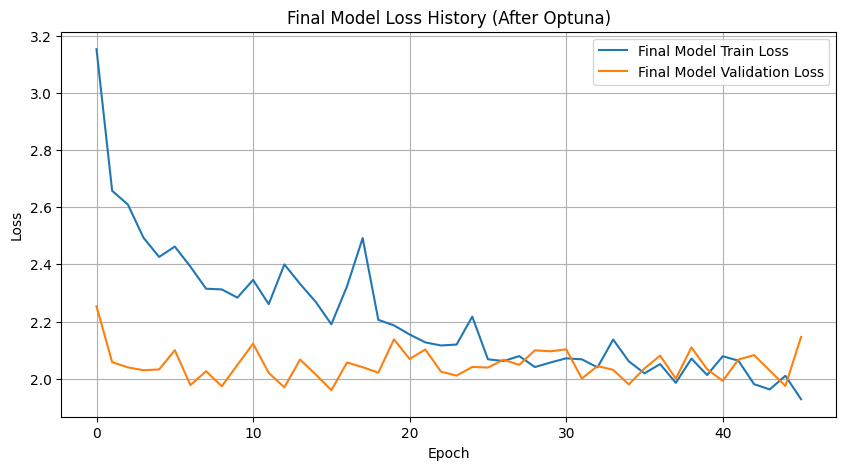

In [10]:
# Cell 9: Optuna HPO 실행
if 'X_train_scaled' in locals() and 'y_train_scaled' in locals() and 'train_loader' in locals() and 'val_loader' in locals(): # 주요 변수 존재 확인
    # input_dim, output_dim을 전역 변수로 설정 (objective 함수에서 사용하기 위함)
    # Cell 7 실행 후 이 값들이 이미 설정되어 있을 수 있습니다.
    # 명시적으로 다시 한번 설정하거나, objective 함수 내에서 안전하게 가져오도록 합니다.
    if 'input_dim' not in globals() or 'input_dim' is None: # None 체크 추가
        input_dim = X_train_scaled.shape[1]
        print(f"Defined input_dim={input_dim} for Optuna objective.")
    if 'output_dim' not in globals() or 'output_dim' is None: # None 체크 추가
        output_dim = y_train_scaled.shape[1]
        print(f"Defined output_dim={output_dim} for Optuna objective.")

    study_name = "fatigue_pinn_hpo_v2"  # 이전 study와 구분되는 새 이름
    # DB에 저장하고 싶을 경우 아래 storage_name 주석 해제
    # storage_name = f"sqlite:///{study_name}.db" 
    
    # MedianPruner: 성능이 낮은 trial을 중간에 중단시켜 효율 증대
    # n_startup_trials: Pruner가 작동하기 전 최소 실행 trial 수
    # n_warmup_steps: 각 trial에서 Pruner가 판단하기 전 최소 epoch 수
    # interval_steps: Pruning 검사 간격 (epoch 단위)
    pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=20, interval_steps=5)

    study = optuna.create_study(
        study_name=study_name,
        # storage=storage_name, # DB 사용 시 주석 해제
        direction='minimize',  # objective 함수가 반환하는 값(검증 손실)을 최소화
        pruner=pruner
    )

    # n_trials: 총 시도 횟수. 시간과 자원을 고려하여 설정
    # timeout: 최대 최적화 시간(초 단위) (선택적)
    # gc_after_trial=True: 각 trial 후 가비지 컬렉션 수행 (메모리 관리에 도움)
    n_optuna_trials = 50 # 예시: 50번 시도
    optuna_timeout_seconds = 7200 # 예시: 2시간

    print(f"\n--- Starting Optuna HPO for {n_optuna_trials} trials (timeout: {optuna_timeout_seconds}s) ---")
    print(f"Study Name: {study_name}")
    # print(f"Storage: {storage_name if 'storage_name' in locals() else 'In-memory'}") # DB 사용 시 storage_name 출력

    try:
        # objective 함수는 Cell 8.5 (가상)에서 정의되었다고 가정
        study.optimize(objective, n_trials=n_optuna_trials, timeout=optuna_timeout_seconds, gc_after_trial=True)
    except KeyboardInterrupt:
        print("\nOptuna optimization stopped by user (KeyboardInterrupt).")
    except Exception as e:
        print(f"\nAn error occurred during Optuna optimization: {e}")
        import traceback
        traceback.print_exc()

    print("\n--- Optuna HPO Complete ---")

    if study.best_trial:
        print(f"Best trial number: {study.best_trial.number}")
        print(f"  Value (min validation loss): {study.best_trial.value:.6f}")
        print("  Best hyperparameters found:")
        for key, value in study.best_params.items():
            print(f"    {key}: {value}")

        # 최적 하이퍼파라미터로 최종 모델 학습 및 저장 (선택적)
        print("\n\n--- Training Final Model with Best Hyperparameters ---")
        best_params = study.best_params
        
        # 1. 최적 파라미터로 모델 다시 정의 (objective 함수 내 모델 정의 부분과 유사)
        final_hidden_dims = [best_params[f'n_units_l{i}'] for i in range(best_params['n_layers'])]
        final_model = FatiguePINN(
            input_dim, 
            output_dim, 
            hidden_dims=final_hidden_dims, 
            dropout_p=best_params['dropout_p']
        ).to(device)
        
        final_optimizer = torch.optim.Adam(final_model.parameters(), lr=best_params['learning_rate'])
        
        # 최적 손실 함수 가중치
        final_epf_weight = best_params['epf_loss_weight']
        final_lambda_physics = best_params['lambda_physics']

        # 2. 최종 학습 루프 (더 많은 epoch, patience 사용 가능)
        final_epochs = 300  # 최종 학습을 위한 epoch 수 (Optuna trial보다 길게)
        final_patience = 30 
        
        best_val_loss_final = float('inf')
        epochs_no_improve_final = 0
        
        train_loss_history_final = []
        val_loss_history_final = []

        print(f"Training final model with: epochs={final_epochs}, lr={best_params['learning_rate']:.6f}, "
              f"epf_weight={final_epf_weight:.4f}, lambda_physics={final_lambda_physics:.4f}")
        print(f"Model architecture: n_layers={best_params['n_layers']}, hidden_dims={final_hidden_dims}, dropout_p={best_params['dropout_p']:.4f}")

        for epoch in range(final_epochs):
            final_model.train()
            epoch_train_loss = 0.0
            for batch_X, batch_y_scaled, batch_E in train_loader:
                batch_X, batch_y_scaled, batch_E = batch_X.to(device), batch_y_scaled.to(device), batch_E.to(device)
                outputs_scaled = final_model(batch_X)
                loss, _, _ = pinn_loss_function(
                    outputs_scaled, batch_y_scaled, batch_E,
                    scalers_y, target_cols,
                    lambda_physics=final_lambda_physics,
                    epf_loss_weight=final_epf_weight,
                    device=device
                )
                final_optimizer.zero_grad()
                loss.backward()
                final_optimizer.step()
                epoch_train_loss += loss.item()
            avg_train_loss = epoch_train_loss / len(train_loader)
            train_loss_history_final.append(avg_train_loss)

            final_model.eval()
            epoch_val_loss = 0.0
            with torch.no_grad():
                for batch_X_val, batch_y_val_scaled, batch_E_val in val_loader:
                    batch_X_val, batch_y_val_scaled, batch_E_val = batch_X_val.to(device), batch_y_val_scaled.to(device), batch_E_val.to(device)
                    outputs_val_scaled = final_model(batch_X_val)
                    val_loss, _, _ = pinn_loss_function(
                        outputs_val_scaled, batch_y_val_scaled, batch_E_val,
                        scalers_y, target_cols,
                        lambda_physics=final_lambda_physics,
                        epf_loss_weight=final_epf_weight,
                        device=device
                    )
                    epoch_val_loss += val_loss.item()
            avg_val_loss = epoch_val_loss / len(val_loader)
            val_loss_history_final.append(avg_val_loss)
            
            print(f"Epoch [{epoch+1}/{final_epochs}], Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")

            if avg_val_loss < best_val_loss_final:
                best_val_loss_final = avg_val_loss
                epochs_no_improve_final = 0
                torch.save(final_model.state_dict(), 'best_fatigue_pinn_model_optuna.pth')
                print(f"  Validation loss improved. Saved best Optuna model to 'best_fatigue_pinn_model_optuna.pth'")
            else:
                epochs_no_improve_final += 1
            
            if epochs_no_improve_final >= final_patience:
                print(f"  Early stopping triggered for final model training after {epoch+1} epochs.")
                break
        
        print("\n--- Final Model Training Complete ---")
        print(f"Best validation loss for final model: {best_val_loss_final:.6f}")

        # 최종 모델 학습 손실 곡선 시각화
        plt.figure(figsize=(10, 5))
        plt.plot(train_loss_history_final, label='Final Model Train Loss')
        plt.plot(val_loss_history_final, label='Final Model Validation Loss')
        plt.title('Final Model Loss History (After Optuna)')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()

    else:
        print("No best trial found. Optuna study might have been interrupted or failed.")

else:
    print("\n데이터가 준비되지 않아 Optuna HPO를 실행할 수 없습니다. 이전 셀들을 먼저 실행해주세요.")
    print("Expected variables: X_train_scaled, y_train_scaled, train_loader, val_loader.")

Successfully loaded 'best_fatigue_pinn_model_optuna.pth'

--- 테스트 세트 평가 중 (Optuna 최적 모델 사용) ---
epf (index 2) 역변환 (np.expm1) applied.

테스트 세트 성능 (원래 스케일, Optuna 최적 모델):
  spf_MPa:
    MSE: 105006.3906
    R2 Score: 0.6655
  b:
    MSE: 0.0006
    R2 Score: 0.3628
  epf:
    MSE: 1.9608
    R2 Score: 0.0558
  c:
    MSE: 0.0128
    R2 Score: 0.3636

예측값 vs. 실제값 그래프 생성 중 (Optuna 최적 모델)...


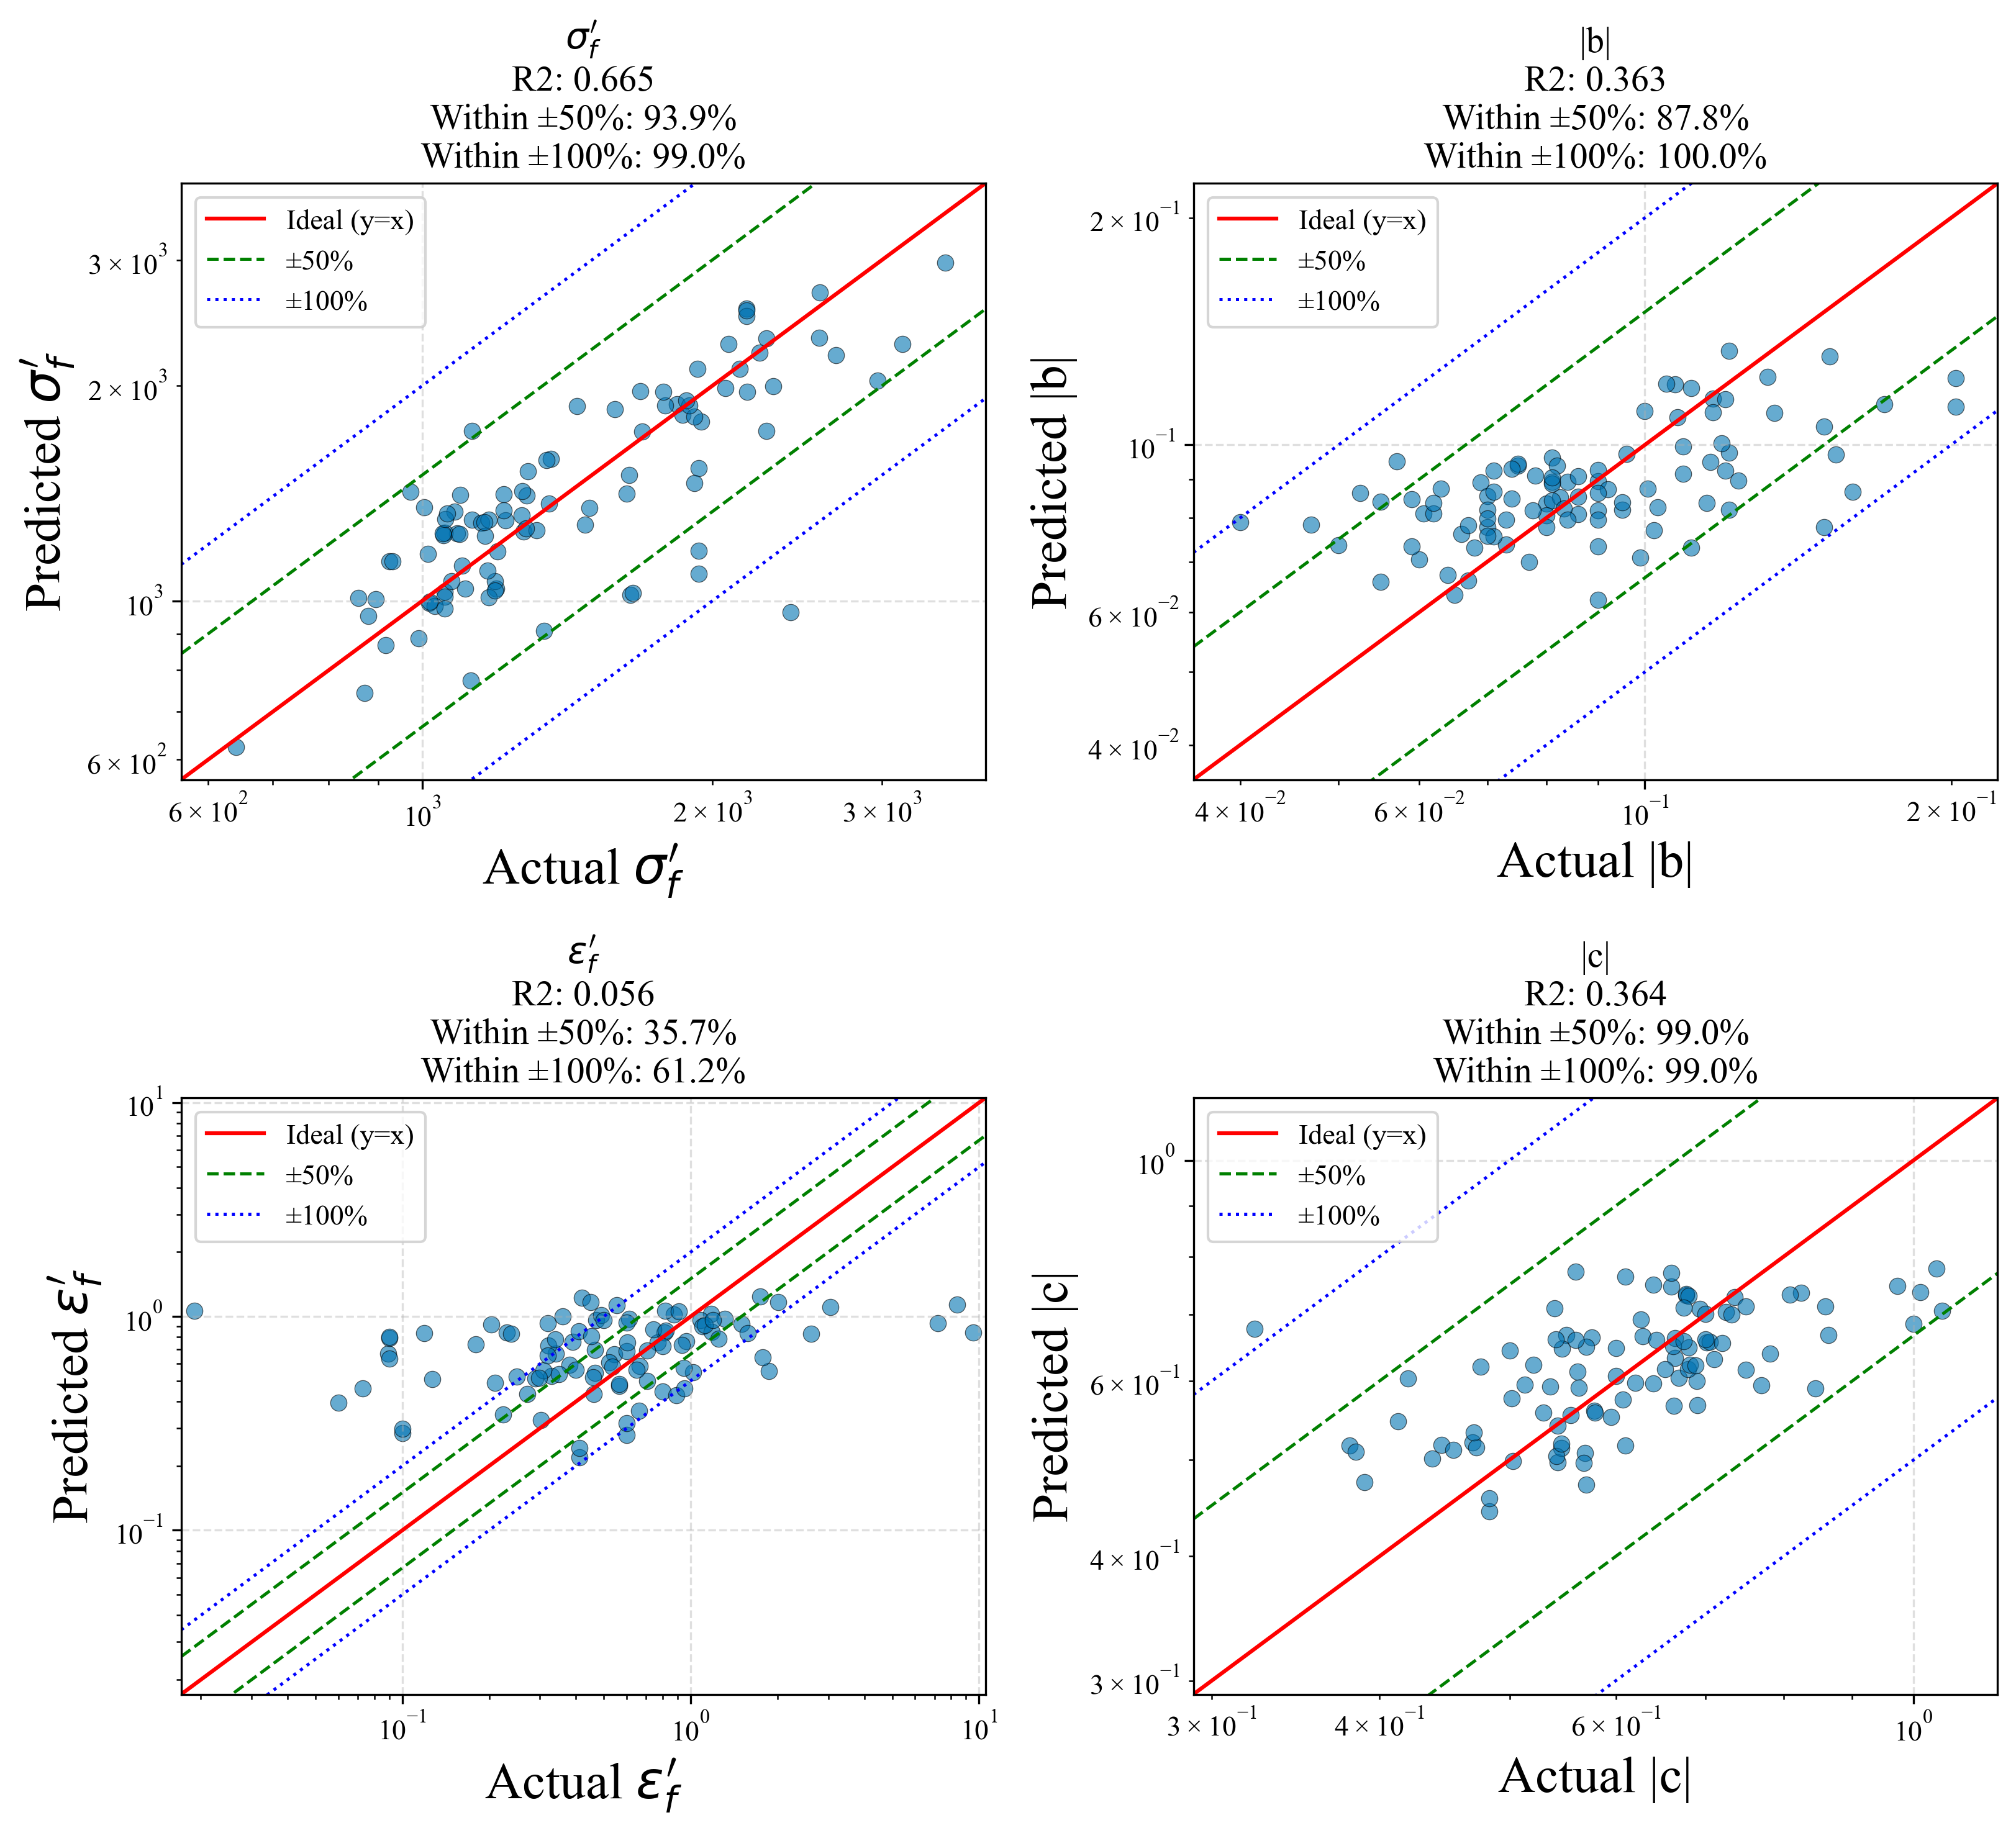

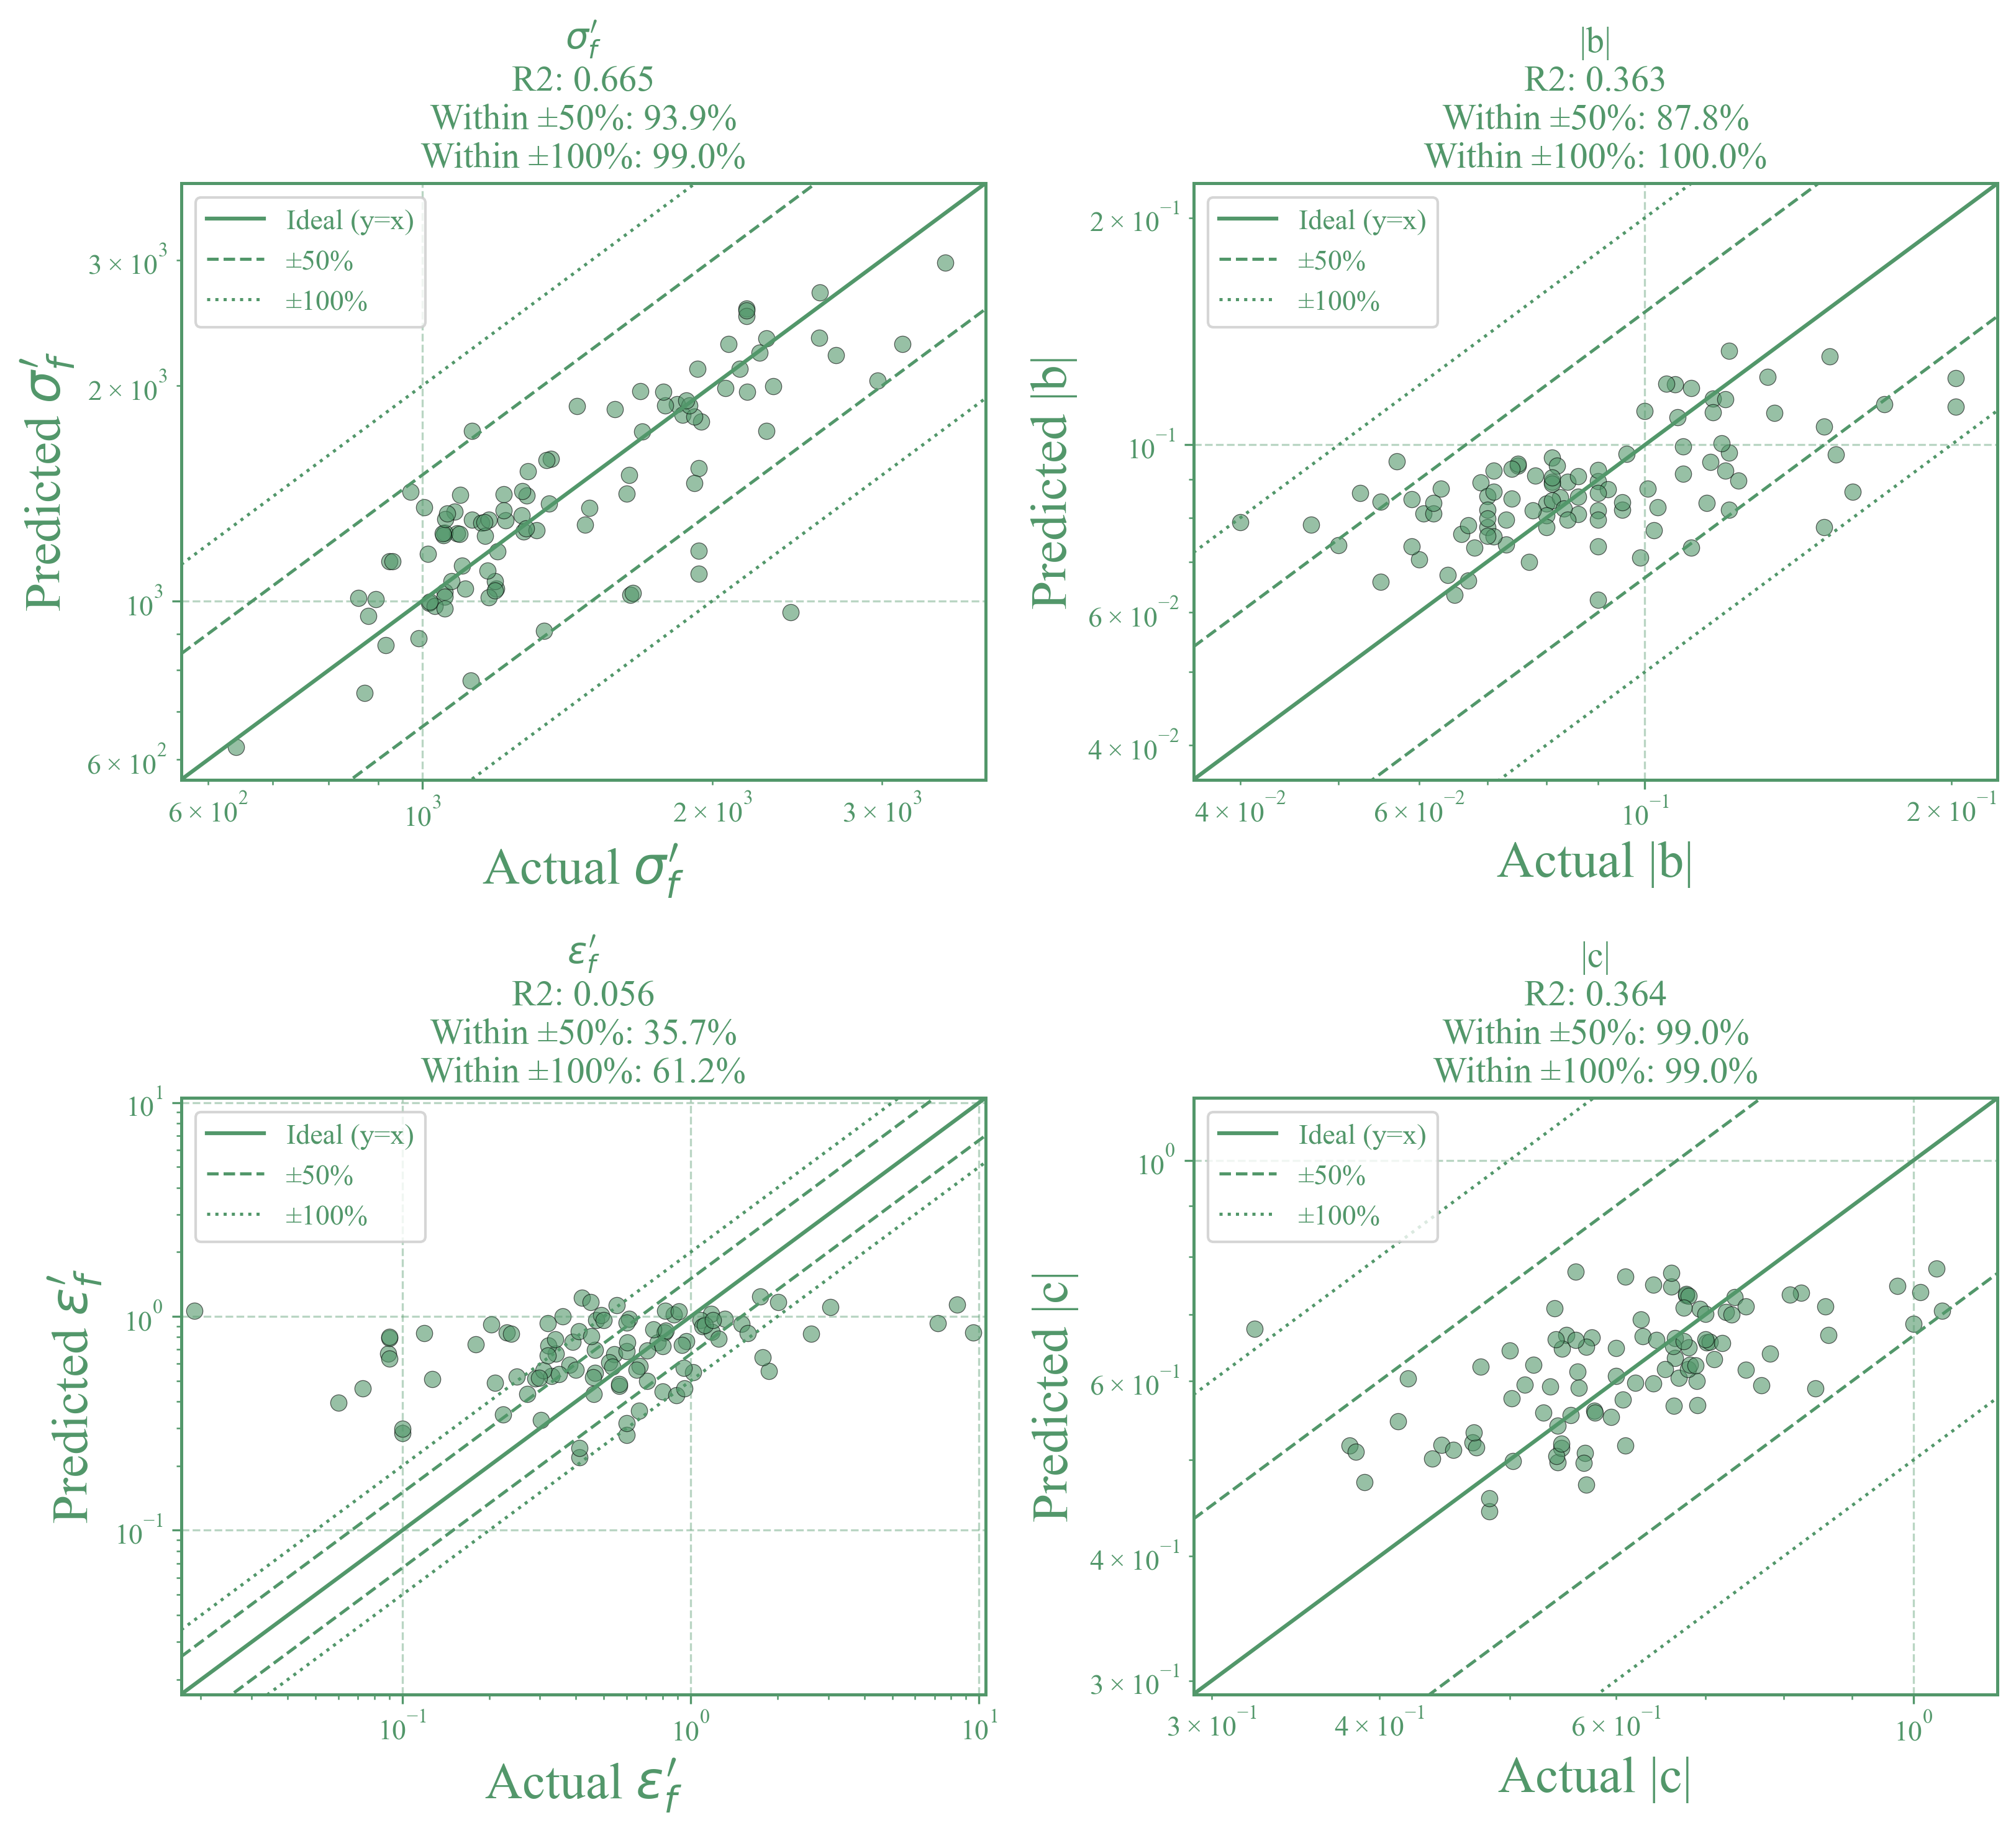

In [12]:
# Cell 10: Evaluation

# Optuna HPO 결과에서 최적 하이퍼파라미터 가져오기
# 이 값들은 Cell 9 실행 후 study.best_params 에서 얻어진 값들입니다.
# 만약 study 객체가 이 셀에서 직접 접근 불가능하면, 해당 값들을 직접 명시해야 합니다.
# 예를 들어, 이전 셀의 출력을 복사하여 사용합니다.

best_params = study.best_params # Cell 9에서 study 객체가 살아있다면 이렇게 가져올 수 있습니다.
# 만약 위 방법이 안되면, Cell 9의 출력에서 직접 값을 가져와 하드코딩합니다.
# best_params = {
#     'n_layers': 3,
#     'n_units_l0': 352,
#     'n_units_l1': 256,
#     'n_units_l2': 192,
#     'dropout_p': 0.35000000000000003,
#     'learning_rate': 0.0003449686791855966, # 평가 시에는 직접 사용되지 않음
#     'epf_loss_weight': 1.0128937438679113,   # 평가 시에는 직접 사용되지 않음
#     'lambda_physics': 0.16907324212725403  # 평가 시에는 직접 사용되지 않음
# }

# 1. 최적 파라미터로 모델 다시 정의 (Cell 9의 final_model 정의와 동일하게)
# input_dim, output_dim은 Cell 7 또는 Cell 9에서 이미 정의되었어야 합니다.
if 'input_dim' not in globals() or 'output_dim' not in globals():
    # Cell 6에서 X_train_scaled, y_train_scaled가 정의되었다고 가정
    if 'X_train_scaled' in globals() and 'y_train_scaled' in globals():
        input_dim = X_train_scaled.shape[1]
        output_dim = y_train_scaled.shape[1]
        print(f"Warning: input_dim/output_dim not found globally. Using shapes from scaled data: input_dim={input_dim}, output_dim={output_dim}")
    else:
        # 이 경우, 적절한 값을 설정하거나 이전 셀을 실행해야 합니다.
        # 임시로 기본값을 설정할 수 있지만, 실제 데이터 차원과 맞아야 합니다.
        raise ValueError("input_dim and output_dim are not defined. Please run previous cells (Cell 6 & 7 or Cell 9 HPO).")

final_hidden_dims = [best_params[f'n_units_l{i}'] for i in range(best_params['n_layers'])]
model_to_evaluate = FatiguePINN( # 새로운 모델 변수명 사용 (예: model_to_evaluate)
    input_dim, 
    output_dim, 
    hidden_dims=final_hidden_dims, 
    dropout_p=best_params['dropout_p']
).to(device)

# Load the best model saved during Optuna's final training phase
try:
    model_to_evaluate.load_state_dict(torch.load('best_fatigue_pinn_model_optuna.pth', map_location=device))
    print("Successfully loaded 'best_fatigue_pinn_model_optuna.pth'")
except FileNotFoundError:
    print("Error: 'best_fatigue_pinn_model_optuna.pth' not found. Make sure the final model training in Cell 9 completed and saved the model.")
    # 또는 이전 모델로 폴백할 수 있습니다.
    # print("Falling back to 'best_fatigue_pinn_model.pth'. This may not reflect Optuna results.")
    # model_to_evaluate.load_state_dict(torch.load('best_fatigue_pinn_model.pth', map_location=device)) 
    raise # 파일을 찾을 수 없으면 여기서 중단하는 것이 나을 수 있습니다.

model_to_evaluate.eval() # Set to evaluation mode

all_preds_scaled = []
all_targets_scaled = []
all_targets_orig = []

print("\n--- 테스트 세트 평가 중 (Optuna 최적 모델 사용) ---")
with torch.no_grad():
    # test_loader는 Cell 6에서 정의되었다고 가정
    for batch_X_test, batch_y_test_scaled, batch_E_test, batch_y_test_orig in test_loader:
        batch_X_test, batch_y_test_scaled = batch_X_test.to(device), batch_y_test_scaled.to(device)

        # Predict scaled parameters using the model_to_evaluate
        outputs_test_scaled = model_to_evaluate(batch_X_test)

        all_preds_scaled.append(outputs_test_scaled.cpu().numpy())
        all_targets_scaled.append(batch_y_test_scaled.cpu().numpy())
        all_targets_orig.append(batch_y_test_orig.cpu().numpy())

# Concatenate results from all batches
all_preds_scaled = np.concatenate(all_preds_scaled, axis=0)
all_targets_scaled = np.concatenate(all_targets_scaled, axis=0)
all_targets_orig = np.concatenate(all_targets_orig, axis=0)

# Inverse transform predictions to original scale
# inverse_transform_targets, scalers_y, target_cols는 Cell 6에서 정의되었다고 가정
all_preds_orig = inverse_transform_targets(all_preds_scaled, scalers_y, target_cols)

# Calculate metrics for each parameter in original scale
metrics = {}
print("\n테스트 세트 성능 (원래 스케일, Optuna 최적 모델):")
for i, param_name in enumerate(target_cols):
    param_pred = all_preds_orig[:, i]
    param_true = all_targets_orig[:, i]

    mse = mean_squared_error(param_true, param_pred)
    r2 = r2_score(param_true, param_pred)
    metrics[param_name] = {'MSE': mse, 'R2': r2}
    print(f"  {param_name}:")
    print(f"    MSE: {mse:.4f}")
    print(f"    R2 Score: {r2:.4f}")

# Visualize Predictions vs. Actuals
print("\n예측값 vs. 실제값 그래프 생성 중 (Optuna 최적 모델)...")

# ... (이하 matplotlib을 사용한 플롯 코드는 기존과 동일하게 유지) ...
# 기존 플롯 코드는 all_preds_orig와 all_targets_orig를 사용하므로,
# 이 변수들이 Optuna 최적 모델의 예측 결과로 채워졌다면 플롯도 자동으로 업데이트됩니다.
import matplotlib as mpl
import matplotlib.pyplot as plt

# Times New Roman 폰트 설정 및 기타 스타일 (전역적용)
mpl.rcParams.update({
    'font.family': 'serif',
    'font.serif': 'Times New Roman',
    'font.size': 12,
    'axes.labelsize': 20,
    'axes.titlesize': 14,
    'legend.fontsize': 11,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'lines.linewidth': 1.8,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'figure.dpi': 300,  
    'axes.unicode_minus': False
})

import seaborn as sns
palette = sns.color_palette("colorblind")

fig, axes = plt.subplots(2, 2, figsize=(11, 10), facecolor='none')
axes = axes.flatten()

for i, param_name in enumerate(target_cols):
    param_pred = all_preds_orig[:, i]
    param_true = all_targets_orig[:, i]
    
    if param_name == 'b' or param_name == 'c':
        param_pred = np.abs(param_pred)
        param_true = np.abs(param_true)
    
    # NaN이나 inf 값을 ratio 계산 전에 처리 (0으로 나누는 것 방지 및 유효한 값만 사용)
    valid_mask = np.isfinite(param_true) & np.isfinite(param_pred) & (param_true != 0)
    param_pred_valid = param_pred[valid_mask]
    param_true_valid = param_true[valid_mask]

    if len(param_true_valid) > 0: # 유효한 데이터가 있을 경우에만 비율 계산
        ratio = param_pred_valid / param_true_valid
        inside_1p5 = np.logical_and(ratio >= 1/1.5, ratio <= 1.5).mean() * 100
        inside_2x = np.logical_and(ratio >= 0.5, ratio <= 2.0).mean() * 100
    else:
        inside_1p5 = 0.0 # 또는 np.nan
        inside_2x = 0.0  # 또는 np.nan
        print(f"Warning: No valid (finite, non-zero denominator) data points for ratio calculation for {param_name}")


    # min_val, max_val 계산 시에도 유효한 데이터만 사용하거나, 전체 데이터에서 NaN/inf 제외
    finite_pred = param_pred[np.isfinite(param_pred)]
    finite_true = param_true[np.isfinite(param_true)]

    if len(finite_pred) > 0 and len(finite_true) > 0:
        min_val_plot = min(finite_pred.min(), finite_true.min()) * 0.9
        max_val_plot = max(finite_pred.max(), finite_true.max()) * 1.1
    elif len(finite_true) > 0 : # 실제값만 유효한 경우
        min_val_plot = finite_true.min() * 0.9
        max_val_plot = finite_true.max() * 1.1
    elif len(finite_pred) > 0 : # 예측값만 유효한 경우
        min_val_plot = finite_pred.min() * 0.9
        max_val_plot = finite_pred.max() * 1.1
    else: # 둘 다 유효한 값이 없는 극단적인 경우
        min_val_plot = 1e-3 
        max_val_plot = 1e1
        print(f"Warning: No finite data for min/max calculation for {param_name}. Using default plot range.")

    if min_val_plot <= 0:
        min_val_plot = 1e-6 
    
    line_vals = np.linspace(min_val_plot, max_val_plot, 100)

    axes[i].scatter(param_true, param_pred, alpha=0.6, s=40, color=palette[0], edgecolor='k', linewidth=0.3)
    axes[i].plot(line_vals, line_vals, 'r-', linewidth=1.5, label='Ideal (y=x)')
    axes[i].plot(line_vals, line_vals * 1.5, 'g--', linewidth=1.2, label='±50%')
    axes[i].plot(line_vals, line_vals / 1.5, 'g--', linewidth=1.2)
    axes[i].plot(line_vals, line_vals * 2.0, 'b:', linewidth=1.2, label='±100%')
    axes[i].plot(line_vals, line_vals * 0.5, 'b:', linewidth=1.2)

    axes[i].set_xscale('log')
    axes[i].set_yscale('log')

    title_str_parts = []
    if param_name == 'b' or param_name == 'c':
        axes[i].set_xlabel(f'Actual |{param_name}|')
        axes[i].set_ylabel(f'Predicted |{param_name}|')
        title_str_parts.append(f'|{param_name}|')
    elif param_name == 'spf_MPa':
        axes[i].set_xlabel(r'Actual $\sigma_f^{\prime}$')
        axes[i].set_ylabel(r'Predicted $\sigma_f^{\prime}$')
        title_str_parts.append(r'$\sigma_f^{\prime}$')
    elif param_name == 'epf':
        axes[i].set_xlabel(r'Actual $\varepsilon_f^{\prime}$')
        axes[i].set_ylabel(r'Predicted $\varepsilon_f^{\prime}$')
        title_str_parts.append(r'$\varepsilon_f^{\prime}$')
    else:
        axes[i].set_xlabel(f'Actual {param_name}')
        axes[i].set_ylabel(f'Predicted {param_name}')
        title_str_parts.append(param_name)
    
    title_str_parts.append(f'R2: {metrics[param_name]["R2"]:.3f}') # R2 스코어 추가
    title_str_parts.append(f'Within ±50%: {inside_1p5:.1f}%')
    title_str_parts.append(f'Within ±100%: {inside_2x:.1f}%')
    axes[i].set_title('\n'.join(title_str_parts))
    
    axes[i].set_xlim(min_val_plot, max_val_plot)
    axes[i].set_ylim(min_val_plot, max_val_plot)
    axes[i].legend(frameon=True, loc='upper left')
    axes[i].grid(True, linestyle='--', alpha=0.4)
    axes[i].set_facecolor('none')

plt.tight_layout()
plt.show()


# 두 번째 그래프 (녹색 테마)
custom_color = (82/255, 151/255, 106/255)
fig2, axes2 = plt.subplots(2, 2, figsize=(11, 10), facecolor='none')
axes2 = axes2.flatten()

for i, param_name in enumerate(target_cols):
    param_pred = all_preds_orig[:, i]
    param_true = all_targets_orig[:, i]
    
    if param_name == 'b' or param_name == 'c':
        param_pred = np.abs(param_pred)
        param_true = np.abs(param_true)
        
    valid_mask = np.isfinite(param_true) & np.isfinite(param_pred) & (param_true != 0)
    param_pred_valid = param_pred[valid_mask]
    param_true_valid = param_true[valid_mask]

    if len(param_true_valid) > 0:
        ratio = param_pred_valid / param_true_valid
        inside_1p5 = np.logical_and(ratio >= 1/1.5, ratio <= 1.5).mean() * 100
        inside_2x = np.logical_and(ratio >= 0.5, ratio <= 2.0).mean() * 100
    else:
        inside_1p5 = 0.0
        inside_2x = 0.0
        
    finite_pred = param_pred[np.isfinite(param_pred)]
    finite_true = param_true[np.isfinite(param_true)]

    if len(finite_pred) > 0 and len(finite_true) > 0:
        min_val_plot = min(finite_pred.min(), finite_true.min()) * 0.9
        max_val_plot = max(finite_pred.max(), finite_true.max()) * 1.1
    elif len(finite_true) > 0 : 
        min_val_plot = finite_true.min() * 0.9
        max_val_plot = finite_true.max() * 1.1
    elif len(finite_pred) > 0 :
        min_val_plot = finite_pred.min() * 0.9
        max_val_plot = finite_pred.max() * 1.1
    else: 
        min_val_plot = 1e-3 
        max_val_plot = 1e1

    if min_val_plot <= 0:
        min_val_plot = 1e-6
        
    line_vals = np.linspace(min_val_plot, max_val_plot, 100)

    axes2[i].scatter(param_true, param_pred, alpha=0.6, s=40, color=custom_color, edgecolor='k', linewidth=0.3)
    axes2[i].plot(line_vals, line_vals, '-', color=custom_color, linewidth=1.5, label='Ideal (y=x)')
    axes2[i].plot(line_vals, line_vals * 1.5, '--', color=custom_color, linewidth=1.2, label='±50%')
    axes2[i].plot(line_vals, line_vals / 1.5, '--', color=custom_color, linewidth=1.2)
    axes2[i].plot(line_vals, line_vals * 2.0, ':', color=custom_color, linewidth=1.2, label='±100%')
    axes2[i].plot(line_vals, line_vals * 0.5, ':', color=custom_color, linewidth=1.2)

    axes2[i].set_xscale('log')
    axes2[i].set_yscale('log')
    
    title_str_parts = []
    # X, Y 레이블 색상 변경 (이전 코드에서 주석 처리된 부분 복원 및 custom_color 적용)
    if param_name == 'b' or param_name == 'c':
        axes2[i].set_xlabel(f'Actual |{param_name}|', color=custom_color)
        axes2[i].set_ylabel(f'Predicted |{param_name}|', color=custom_color)
        title_str_parts.append(f'|{param_name}|')
    elif param_name == 'spf_MPa':
        axes2[i].set_xlabel(r'Actual $\sigma_f^{\prime}$', color=custom_color)
        axes2[i].set_ylabel(r'Predicted $\sigma_f^{\prime}$', color=custom_color)
        title_str_parts.append(r'$\sigma_f^{\prime}$')
    elif param_name == 'epf':
        axes2[i].set_xlabel(r'Actual $\varepsilon_f^{\prime}$', color=custom_color)
        axes2[i].set_ylabel(r'Predicted $\varepsilon_f^{\prime}$', color=custom_color)
        title_str_parts.append(r'$\varepsilon_f^{\prime}$')
    else:
        axes2[i].set_xlabel(f'Actual {param_name}', color=custom_color)
        axes2[i].set_ylabel(f'Predicted {param_name}', color=custom_color)
        title_str_parts.append(param_name)
        
    title_str_parts.append(f'R2: {metrics[param_name]["R2"]:.3f}')
    title_str_parts.append(f'Within ±50%: {inside_1p5:.1f}%')
    title_str_parts.append(f'Within ±100%: {inside_2x:.1f}%')
    axes2[i].set_title('\n'.join(title_str_parts), color=custom_color)
    
    axes2[i].set_xlim(min_val_plot, max_val_plot)
    axes2[i].set_ylim(min_val_plot, max_val_plot)
    # legend 라벨 색상도 custom_color로 변경
    legend = axes2[i].legend(frameon=True, loc='upper left')
    for text in legend.get_texts():
        text.set_color(custom_color)
        
    axes2[i].grid(True, linestyle='--', alpha=0.4, color=custom_color)
    axes2[i].set_facecolor('none')
    
    for spine in axes2[i].spines.values():
        spine.set_color(custom_color)
        spine.set_linewidth(1.2)
    
    axes2[i].tick_params(axis='both', colors=custom_color, which='both') # which='both' 추가
    
    # 눈금 레이블 색상도 명시적으로 변경
    for label in axes2[i].get_xticklabels(which='both'): # which='both' 추가
        label.set_color(custom_color)
    for label in axes2[i].get_yticklabels(which='both'): # which='both' 추가
        label.set_color(custom_color)

plt.tight_layout()
plt.show()


In [ ]:
# Cell 11: E-N 및 Gamma-N 곡선 생성 함수 

# df 변수 확인 없이 바로 함수 정의
def predict_fatigue_curves(E_val, YS_val, TS_val, HB_val, model, scaler_X, 
                           scalers_y_dict, target_cols_list,  # 수정된 부분
                           device, mode='both', nu=0.3):
    """
    인장 파라미터를 예측하고 E-N 및 Gamma-N 곡선 데이터를 생성합니다.

    Args:
        E_val (float): 탄성 계수 (MPa)
        YS_val (float): 항복 강도 (MPa)
        TS_val (float): 인장 강도 (MPa)
        HB_val (float): 브리넬 경도 (처리된 값)
        model (torch.nn.Module): 학습된 FatiguePINN 모델
        scaler_X (StandardScaler): 입력 특성에 대한 스케일러
        scalers_y_dict (dict): 출력 파라미터별 스케일러 딕셔너리
        target_cols_list (list): 타겟 컬럼 이름 리스트
        device (str): 장치 ('cpu', 'cuda', 'mps')
        mode (str, optional): 반환 모드 ('tensile', 'shear', 'both'). 기본값은 'both'.
        nu (float, optional): 포아송 비. 기본값은 0.3.

    Returns:
        mode에 따라 다른 값을 반환합니다:
        - 'tensile': (tensile_params, reversals, strain_amplitude_en, elastic_strain, plastic_strain)
        - 'shear': (shear_params, reversals, strain_amplitude_gn, elastic_shear_strain, plastic_shear_strain)
        - 'both': (tensile_params, reversals, strain_amplitude_en, elastic_strain, plastic_strain,
                  shear_params, reversals, strain_amplitude_gn, elastic_shear_strain, plastic_shear_strain)
    """
    model.eval() # 모델을 평가 모드로 설정

    # --- 1. 인장 파라미터 예측 ---
    input_features = np.array([[E_val, YS_val, TS_val, HB_val]])
    input_scaled = scaler_X.transform(input_features)
    input_tensor = torch.tensor(input_scaled, dtype=torch.float32).to(device)

    with torch.no_grad():
        predicted_tensile_params_scaled = model(input_tensor)
    
    # 모델 예측 결과 역변환 부분 수정
    predicted_tensile_params_scaled_np = predicted_tensile_params_scaled.cpu().numpy()
    predicted_tensile_params_orig = inverse_transform_targets(
        predicted_tensile_params_scaled_np,
        scalers_y_dict,
        target_cols_list
    )

    try:
        # 1. tensile_params 생성 단계
        tensile_params = {name_key: p_val for name_key, p_val in zip(target_cols_list, predicted_tensile_params_orig)}

        # 2. 키 확인 단계
        required_tensile_keys = ['spf_MPa', 'b', 'epf', 'c']
        if not all(key in tensile_params for key in required_tensile_keys):
            raise ValueError(f"Missing keys in tensile_params. Required: {required_tensile_keys}, Got: {tensile_params.keys()}")

        # 3. 파라미터 추출 단계
        spf_prime = tensile_params['spf_MPa']
        b_param = tensile_params['b'] 
        epf_prime = tensile_params['epf']
        c_param = tensile_params['c'] 

        reversals = np.logspace(1, 7, num=100)
        E_val_safe = max(E_val, 1e-6)
        
        # 4. elastic_strain 계산 단계
        if not isinstance(b_param, (int, float, np.number)):
            raise TypeError("b_param for exponent must be a number.")
        elastic_strain = (spf_prime / E_val_safe) * (reversals ** b_param)
        
        # 5. plastic_strain 계산 단계
        if not isinstance(c_param, (int, float, np.number)):
             raise TypeError("c_param for exponent must be a number.")
        plastic_strain = epf_prime * (reversals ** c_param)
        
        strain_amplitude_en = elastic_strain + plastic_strain

        if mode == 'tensile':
            return tensile_params, reversals, strain_amplitude_en, elastic_strain, plastic_strain

        # --- 전단 파라미터 변환 ---
        tau_vm = spf_prime / np.sqrt(3)
        gamma_vm = np.sqrt(3) * epf_prime
        tau_mp = spf_prime / (1 + nu)
        gamma_mp = 2 * epf_prime

        if TS_val <= 1100:
            tauf_prime, gammaf_prime, b0, c0, conversion_method = tau_vm, gamma_vm, b_param, c_param, "von Mises"
        elif TS_val >= 1696:
            tauf_prime, gammaf_prime, b0, c0, conversion_method = tau_mp, gamma_mp, b_param, c_param, "Max Principal"
        else:
            alpha = (TS_val - 1100) / (1696 - 1100)
            tauf_prime = (1-alpha)*tau_vm + alpha*tau_mp
            gammaf_prime = (1-alpha)*gamma_vm + alpha*gamma_mp
            b0, c0, conversion_method = b_param, c_param, f"Interp VM→MP (α={alpha:.2f})"
        
        shear_params = {'tauf_MPa': tauf_prime, 'gammaf': gammaf_prime, 'b0': b0, 'c0': c0, 'conversion_method': conversion_method}
        G_val = E_val_safe / (2 * (1 + nu))
        
        if not isinstance(b0, (int, float, np.number)):
             raise TypeError("b0 for exponent must be a number.")
        if not isinstance(c0, (int, float, np.number)):
             raise TypeError("c0 for exponent must be a number.")

        elastic_shear_strain = (tauf_prime / G_val) * (reversals ** b0)
        plastic_shear_strain = gammaf_prime * (reversals ** c0)
        strain_amplitude_gn = elastic_shear_strain + plastic_shear_strain

        if mode == 'shear':
            return shear_params, reversals, strain_amplitude_gn, elastic_shear_strain, plastic_shear_strain
        
        return tensile_params, reversals, strain_amplitude_en, elastic_strain, plastic_strain, \
               shear_params, reversals, strain_amplitude_gn, elastic_shear_strain, plastic_shear_strain

    except TypeError as te_inner:
        # 스택 트레이스를 포함하여 출력하면 더 도움이 됩니다.
        import traceback
        print(traceback.format_exc())
        raise 
    except Exception as e_inner:
        import traceback
        print(traceback.format_exc())
        raise

# --- 함수 테스트 ---
print("\n--- Testing E-N and Gamma-N Curve Generation ---")
try:
    # feature_cols가 이전에 정의되었는지 확인 (Cell 4에서 정의됨)
    if 'feature_cols' not in locals() and 'feature_cols' not in globals():
        print("Error: 'feature_cols'가 정의되지 않았습니다. Cell 4를 먼저 실행해주세요.")
        raise NameError("'feature_cols' not defined")
        
    example_input_X_row = X_test[0]  # X_test의 첫 번째 행
    example_E_val = E_test[0]        # 해당 샘플의 E 값

    # feature_cols 리스트에서 각 특성의 정확한 인덱스를 가져옵니다.
    ys_col_name_in_features = 'YS_MPa'
    ts_col_name_in_features = 'TS_MPa'
    hb_col_name_in_features = 'HB_processed'  # 'HB'가 아닌 'HB_processed' 사용!

    ys_idx = feature_cols.index(ys_col_name_in_features)
    ts_idx = feature_cols.index(ts_col_name_in_features)
    hb_idx = feature_cols.index(hb_col_name_in_features)  # 오류 발생 지점 수정

    # 추출된 인덱스를 사용하여 값을 가져옵니다.
    example_YS_val = example_input_X_row[ys_idx]
    example_TS_val = example_input_X_row[ts_idx]
    example_HB_val = example_input_X_row[hb_idx]

    print(f"Example Input (from X_test[0] using feature_cols: {feature_cols}):")
    print(f"  E: {example_E_val:.0f} MPa")
    print(f"  {ys_col_name_in_features} (Index: {ys_idx}): {example_YS_val:.0f} MPa")
    print(f"  {ts_col_name_in_features} (Index: {ts_idx}): {example_TS_val:.0f} MPa")
    print(f"  {hb_col_name_in_features} (Index: {hb_idx}): {example_HB_val:.1f}")  # 변수명 일치

    # predict_fatigue_curves 함수 호출
    tensile_p, rev_en, strain_en, elastic_strain, plastic_strain, \
    shear_p, rev_gn, strain_gn, elastic_shear_strain, plastic_shear_strain = predict_fatigue_curves(
        example_E_val, example_YS_val, example_TS_val, example_HB_val,  # 추출된 변수 사용
        model, scaler_X, scalers_y, target_cols,  # 수정된 스케일러 및 타겟 정보 전달
        device, mode='both', nu=0.3
    )

    print("\n인장 파라미터 예측 결과:")
    for name, val in tensile_p.items(): print(f"  {name}: {val:.4f}")

    print("\n전단 파라미터 예측 결과:")
    for name, val in shear_p.items(): print(f"  {name}: {val if isinstance(val, str) else f'{val:.4f}'}")

    # E-N 곡선 플롯 (구성 요소 포함)
    plt.figure(figsize=(8, 6))
    plt.loglog(rev_en, strain_en, '-', label='Total Strain (epsilon_a)')
    plt.loglog(rev_en, elastic_strain, '--', label='Elastic Strain', alpha=0.7)
    plt.loglog(rev_en, plastic_strain, ':', label='Plastic Strain', alpha=0.7)
    plt.xlabel('Reversals to Failure (2Nf)')
    plt.ylabel('Strain Amplitude (epsilon_a)')
    plt.title('Predicted E-N Curve (with Components)')
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.ylim(bottom=1e-4)
    plt.show()

    # Gamma-N 곡선 플롯 (구성 요소 포함)
    plt.figure(figsize=(8, 6))
    plt.loglog(rev_gn, strain_gn, '-', label='Total Shear Strain (gamma_a)')
    plt.loglog(rev_gn, elastic_shear_strain, '--', label='Elastic Shear Strain', alpha=0.7)
    plt.loglog(rev_gn, plastic_shear_strain, ':', label='Plastic Shear Strain', alpha=0.7)
    plt.xlabel('Reversals to Failure (2Nf)')
    plt.ylabel('Shear Strain Amplitude (gamma_a)')
    plt.title(f'Predicted Gamma-N Curve (UTS={example_TS_val:.0f}, Method: {shear_p["conversion_method"]})')
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.ylim(bottom=1e-4)
    plt.show()

except ValueError as ve:
    print(f"테스트 중 값 관련 오류 발생 (특성 이름 확인 필요): {ve}")  # 더 구체적인 오류 메시지
except NameError as ne:
    print(f"오류: 테스트 데이터(X_test, E_test) 또는 모델/스케일러를 사용할 수 없습니다. 이전 셀을 실행하세요. {ne}")
except IndexError:
    print("오류: 테스트 데이터가 비어 있거나 형태가 올바르지 않습니다.")
except Exception as e:
    print(f"테스트 중 오류가 발생했습니다: {e}")
